<a href="https://colab.research.google.com/github/tariqshaban/progresssoft-electric-consumption-forecast/blob/master/electric_consumption_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Parameters

In [1]:
TRAINING_RATIO = 0.90
VALIDATION_RATIO = 0.05

SLIDING_WINDOW_SIZE = 168

LSTM_HIDDEN_NEURON_COUNT = 200
LSTM_DROPOUT_P = 0.2

TRANSFORMER_NUMBER_OF_HEADS = 4
TRANSFORMER_HIDDEN_NEURON_COUNT = 200
TRANSFORMER_DROPOUT_P = 0.2

BATCH_SIZE = 1024
NUMBER_OF_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 20

### Assertions

In [2]:
assert 0 < TRAINING_RATIO < 1.0, 'Value ratio must be between 0.0 and 1.0'
assert 0 < VALIDATION_RATIO < 1.0, 'Validation ratio must be between 0.0 and 1.0'
assert 0 < TRAINING_RATIO + VALIDATION_RATIO < 1.0, 'Training and validation ratios must be between 0.0 and 1.0'

assert SLIDING_WINDOW_SIZE >= 0 and SLIDING_WINDOW_SIZE == int(SLIDING_WINDOW_SIZE), 'Window step must be a non-negative integer'

assert LSTM_HIDDEN_NEURON_COUNT > 0 and LSTM_HIDDEN_NEURON_COUNT == int(LSTM_HIDDEN_NEURON_COUNT), 'LSTM neurons must be a positive integer'
assert 0 < LSTM_DROPOUT_P < 1.0, 'LSTM dropout ratio must be between 0.0 and 1.0'

assert TRANSFORMER_NUMBER_OF_HEADS > 0 and TRANSFORMER_NUMBER_OF_HEADS == int(TRANSFORMER_NUMBER_OF_HEADS), 'Transformer number of heads must be a positive integer'
assert TRANSFORMER_HIDDEN_NEURON_COUNT > 0 and TRANSFORMER_HIDDEN_NEURON_COUNT == int(TRANSFORMER_HIDDEN_NEURON_COUNT), 'Transformer neurons must be a positive integer'
assert 0 < TRANSFORMER_DROPOUT_P < 1.0, 'Transformer dropout ratio must be between 0.0 and 1.0'

assert BATCH_SIZE > 0 and BATCH_SIZE == int(BATCH_SIZE), 'Early stopping patience must be a positive integer'
assert NUMBER_OF_EPOCHS > 0 and NUMBER_OF_EPOCHS == int(NUMBER_OF_EPOCHS), 'Number of epochs must be a positive integer'
assert EARLY_STOPPING_PATIENCE > 0 and EARLY_STOPPING_PATIENCE == int(EARLY_STOPPING_PATIENCE), 'Early stopping patience must be a positive integer'

# Importing Dependencies

In [3]:
import calplot
import holidays
import keras
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import time

from numpy.lib.stride_tricks import as_strided
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from tensorflow.keras.utils import Sequence

# Common Methods

In [4]:
# Make column names more readable when displayed in plots
def format_column_name(x: str) -> str:
    return x.replace('_', ' ').title()

# Load Dataset

In [5]:
# Read from the dataframe
df = pd.read_parquet('assets/dataset/household_power_consumption.parquet')
df

Date      Time  Global_active_power  Global_reactive_power  \
0        16/12/2006  17:24:00                4.216                  0.418   
1        16/12/2006  17:25:00                5.360                  0.436   
2        16/12/2006  17:26:00                5.374                  0.498   
3        16/12/2006  17:27:00                5.388                  0.502   
4        16/12/2006  17:28:00                3.666                  0.528   
...             ...       ...                  ...                    ...   
2075254  26/11/2010  20:58:00                0.946                  0.000   
2075255  26/11/2010  20:59:00                0.944                  0.000   
2075256  26/11/2010  21:00:00                0.938                  0.000   
2075257  26/11/2010  21:01:00                0.934                  0.000   
2075258  26/11/2010  21:02:00                0.932                  0.000   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
0         234.84              18.4             0.0             1.0   
1         233.63              23.0             0.0             1.0   
2         233.29              23.0             0.0             2.0   
3         233.74              23.0             0.0             1.0   
4         235.68              15.8             0.0             1.0   
...          ...               ...             ...             ...   
2075254   240.43               4.0             0.0             0.0   
2075255   240.00               4.0             0.0             0.0   
2075256   239.82               3.8             0.0             0.0   
2075257   239.70               3.8             0.0             0.0   
2075258   239.55               3.8             0.0             0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [6]:
# Check columns' data type
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [7]:
# Show brief statistical analysis of each column
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

# Preprocessing

In [8]:
# Create a composite datetime column as index
df.insert(0, 'DateTime', pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True))
df.set_index('DateTime', inplace=True)

In [9]:
# Remove date and time columns
df.drop(columns=['Date', 'Time'], inplace=True)

In [10]:
# Check for partial null records
df_nans = df[df.isnull().any(axis=1)]
df_nans

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 19:09:00                  NaN                    NaN      NaN   
2010-09-28 19:10:00                  NaN                    NaN      NaN   
2010-09-28 19:11:00                  NaN                    NaN      NaN   
2010-09-28 19:12:00                  NaN                    NaN      NaN   
2010-10-24 15:35:00                  NaN                    NaN      NaN   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-21 11:23:00               NaN             NaN             NaN   
2006-12-21 11:24:00               NaN             NaN             NaN   
2006-12-30 10:08:00               NaN             NaN             NaN   
2006-12-30 10:09:00               NaN             NaN             NaN   
2007-01-14 18:36:00               NaN             NaN             NaN   
...                               ...             ...             ...   
2010-09-28 19:09:00               NaN             NaN             NaN   
2010-09-28 19:10:00               NaN             NaN             NaN   
2010-09-28 19:11:00               NaN             NaN             NaN   
2010-09-28 19:12:00               NaN             NaN             NaN   
2010-10-24 15:35:00               NaN             NaN             NaN   

                     Sub_metering_3  
DateTime                             
2006-12-21 11:23:00             NaN  
2006-12-21 11:24:00             NaN  
2006-12-30 10:08:00             NaN  
2006-12-30 10:09:00             NaN  
2007-01-14 18:36:00             NaN  
...                             ...  
2010-09-28 19:09:00             NaN  
2010-09-28 19:10:00             NaN  
2010-09-28 19:11:00             NaN  
2010-09-28 19:12:00             NaN  
2010-10-24 15:35:00             NaN  

[25979 rows x 7 columns]

In [11]:
# Check for complete null records
df_nans = df[df.isnull().all(axis=1)]
df_nans

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 19:09:00                  NaN                    NaN      NaN   
2010-09-28 19:10:00                  NaN                    NaN      NaN   
2010-09-28 19:11:00                  NaN                    NaN      NaN   
2010-09-28 19:12:00                  NaN                    NaN      NaN   
2010-10-24 15:35:00                  NaN                    NaN      NaN   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-21 11:23:00               NaN             NaN             NaN   
2006-12-21 11:24:00               NaN             NaN             NaN   
2006-12-30 10:08:00               NaN             NaN             NaN   
2006-12-30 10:09:00               NaN             NaN             NaN   
2007-01-14 18:36:00               NaN             NaN             NaN   
...                               ...             ...             ...   
2010-09-28 19:09:00               NaN             NaN             NaN   
2010-09-28 19:10:00               NaN             NaN             NaN   
2010-09-28 19:11:00               NaN             NaN             NaN   
2010-09-28 19:12:00               NaN             NaN             NaN   
2010-10-24 15:35:00               NaN             NaN             NaN   

                     Sub_metering_3  
DateTime                             
2006-12-21 11:23:00             NaN  
2006-12-21 11:24:00             NaN  
2006-12-30 10:08:00             NaN  
2006-12-30 10:09:00             NaN  
2007-01-14 18:36:00             NaN  
...                             ...  
2010-09-28 19:09:00             NaN  
2010-09-28 19:10:00             NaN  
2010-09-28 19:11:00             NaN  
2010-09-28 19:12:00             NaN  
2010-10-24 15:35:00             NaN  

[25979 rows x 7 columns]

In [12]:
# Fill null records with values exactly before and/or after a year
def fill_with_year_mean(row) -> pd.Series:
    current_date = row.name
    year_before = current_date - pd.DateOffset(years=1)
    year_after = current_date + pd.DateOffset(years=1)

    try:
        before_row = df.loc[year_before]
    except KeyError:
        before_row = None

    try:
        after_row = df.loc[year_after]
    except KeyError:
        after_row = None

    is_below_row_valid = before_row is not None and not before_row.isnull().any()
    is_after_row_valid = after_row is not None and not after_row.isnull().any()

    if is_below_row_valid and is_after_row_valid:
        row = (before_row + after_row) / 2
    elif is_below_row_valid:
        row = before_row
    elif is_after_row_valid:
        row = after_row
    else:
        raise Exception('Could not find previous or later year')

    return row


records_with_nan = df.isnull().any(axis=1)
df.loc[records_with_nan] = df.loc[records_with_nan].apply(fill_with_year_mean, axis=1)

### Assertions

#### Verify no null values in dataset

In [13]:
assert df[df.isnull().any(axis=1)].empty, 'Null values exists'

#### Given a sample date with null values and non-null values for next and previous year when comparing then return no discrepancy

In [14]:
null_sample_date = df_nans.iloc[8000].name

df_compare = df.loc[null_sample_date].compare((df.loc[null_sample_date - pd.DateOffset(years=1)] + df.loc[null_sample_date + pd.DateOffset(years=1)]) / 2)

assert df_compare.empty, 'Dataframes are not equal'

#### Given a sample date with null values and non-null values for next year and no previous year when comparing then return no discrepancy

In [15]:
null_sample_date = df_nans.iloc[0].name

assert null_sample_date - pd.DateOffset(years=1) < df.index.min(), 'Sample has a previous year'

df_compare = df.loc[null_sample_date].compare(df.loc[null_sample_date + pd.DateOffset(years=1)])

assert df_compare.empty, 'Dataframes are not equal'

#### Given a sample date with null values and non-null values for previous year and no next year when comparing then return no discrepancy

In [16]:
null_sample_date = df_nans.iloc[-1].name

assert null_sample_date + pd.DateOffset(years=1) > df.index.max(), 'Sample has a next year'

df_compare = df.loc[null_sample_date].compare(df.loc[null_sample_date - pd.DateOffset(years=1)])

assert df_compare.empty, 'Dataframes are not equal'

### Add Metadata

In [17]:
# Insert holiday flag and temporal columns while preserving cyclical nature
holidays_france = holidays.FR(years=df.index.year.unique())
holidays_france = pd.to_datetime(list(holidays_france.keys()))

df['year'] = df.index.year

df['month_sin'] = np.sin(2. * np.pi * df.index.month / 12.)
df['month_cos'] = np.cos(2. * np.pi * df.index.month / 12.)

df['day_sin'] = np.sin(2. * np.pi * df.index.day / 31.)
df['day_cos'] = np.cos(2. * np.pi * df.index.day / 31.)

df['hour_sin'] = np.sin(2. * np.pi * df.index.hour / 24.)
df['hour_cos'] = np.cos(2. * np.pi * df.index.hour / 24.)

df['minute_sin'] = np.sin(2. * np.pi * df.index.minute / 60.)
df['minute_cos'] = np.cos(2. * np.pi * df.index.minute / 60.)

df['is_holiday'] = df.index.normalize().isin(holidays_france).astype(int)

# EDA

In [18]:
temporal_features = ['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']
features = [x for x in df.columns if x not in temporal_features]
power_features = [x for x in features if x != 'Voltage' and x != 'is_holiday']

### Distribution Plot

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>,
        <Axes: title={'center': 'is_holiday'}>, <Axes: >]], dtype=object)

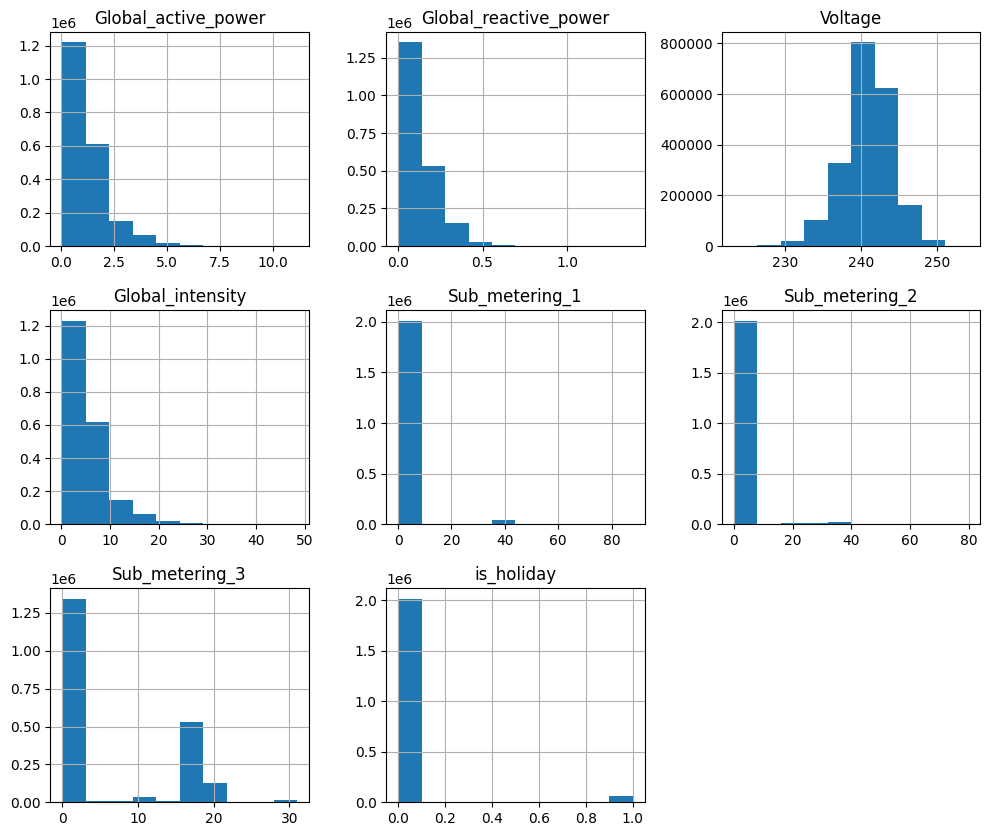

In [19]:
# Plots a histogram
df[features].hist(figsize=(12, 10))

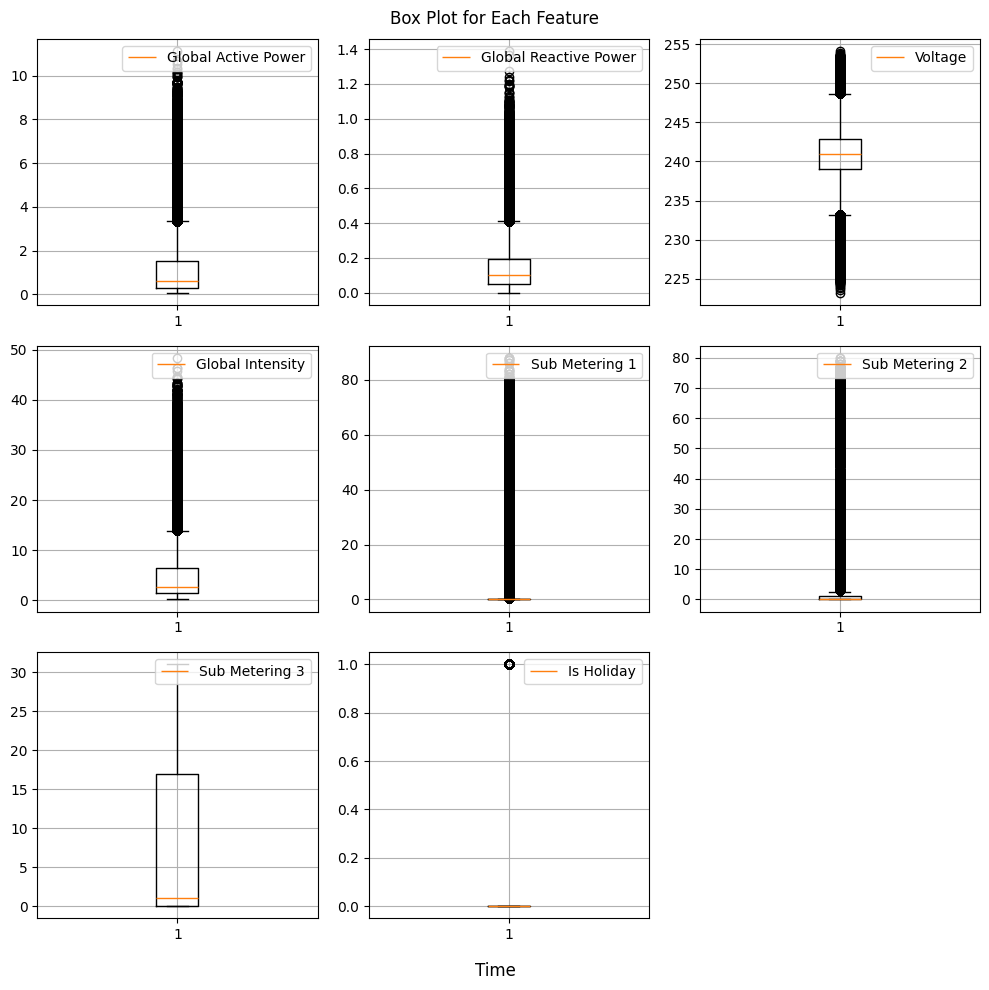

In [20]:
# Plots a boxplot
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Box Plot for Each Feature')
fig.supxlabel('Time')
ax = ax.flatten()
for idx, col in enumerate(features):
    ax[idx].boxplot(df[col], label=format_column_name(col))
    ax[idx].legend(loc='upper right')
    ax[idx].grid(True)

for idx in range(len(features), len(ax)):
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

### Power Plots for Different Periods (Yearly, Monthly, Daily, and Hourly)

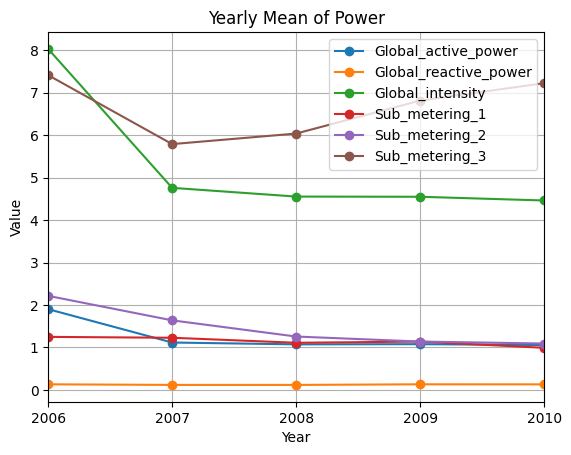

In [21]:
# Plots the average power features trend over the years
df_yearly = df.groupby(df.index.year).mean()

fig, ax = plt.subplots()

for col in power_features:
    ax.plot(df_yearly.index, df_yearly[col], marker='o', label=col)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Yearly Mean of Power')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

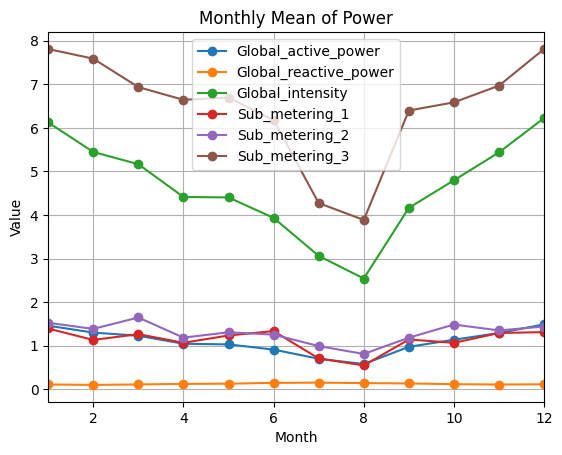

In [22]:
# Plots the average power features trend over the months
df_monthly = df.groupby(df.index.month).mean()

fig, ax = plt.subplots()

for col in power_features:
    ax.plot(df_monthly.index, df_monthly[col], marker='o', label=col)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Month')
ax.set_ylabel('Value')
ax.set_title('Monthly Mean of Power')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

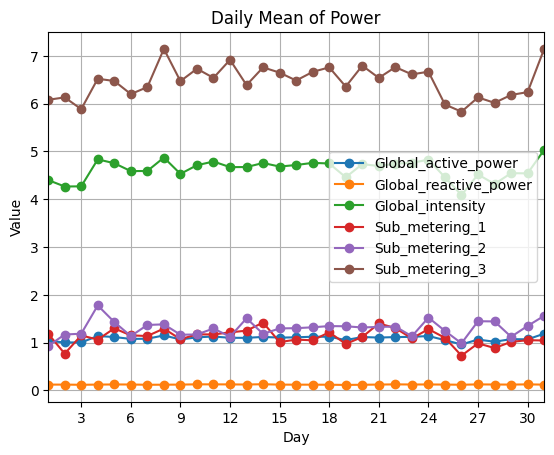

In [23]:
# Plots the average power features trend over the days
df_daily = df.groupby(df.index.day).mean()

fig, ax = plt.subplots()

for col in power_features:
    ax.plot(df_daily.index, df_daily[col], marker='o', label=col)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Day')
ax.set_ylabel('Value')
ax.set_title('Daily Mean of Power')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

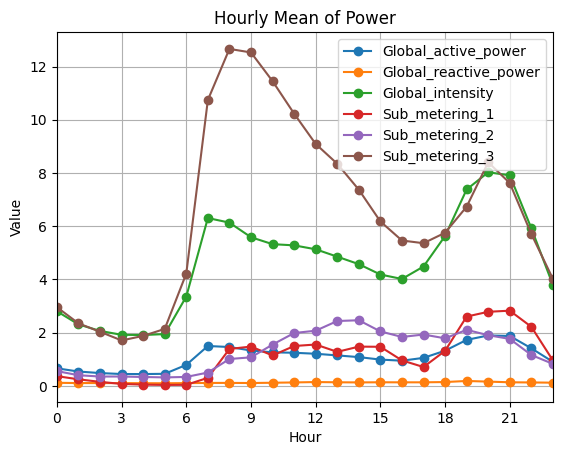

In [24]:
# Plots the average power features trend over the hours
df_hourly = df.groupby(df.index.hour).mean()

fig, ax = plt.subplots()

for col in power_features:
    ax.plot(df_hourly.index, df_hourly[col], marker='o', label=col)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Hour')
ax.set_ylabel('Value')
ax.set_title('Hourly Mean of Power')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

### Voltage Plots for Different Periods (Yearly, Monthly, Daily, and Hourly)

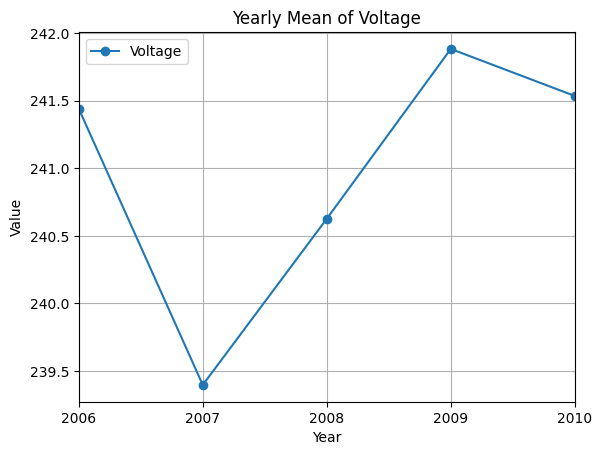

In [25]:
# Plots the average voltage feature trend over the years
df_yearly = df.groupby(df.index.year).mean()

fig, ax = plt.subplots()

ax.plot(df_yearly.index, df_yearly['Voltage'], marker='o', label='Voltage')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Year')
ax.set_ylabel('Value')
ax.set_title('Yearly Mean of Voltage')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

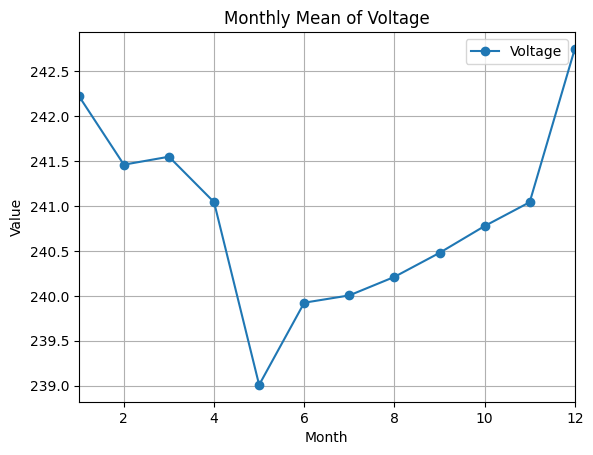

In [26]:
# Plots the average voltage feature trend over the years
df_monthly = df.groupby(df.index.month).mean()

fig, ax = plt.subplots()

ax.plot(df_monthly.index, df_monthly['Voltage'], marker='o', label='Voltage')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Month')
ax.set_ylabel('Value')
ax.set_title('Monthly Mean of Voltage')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

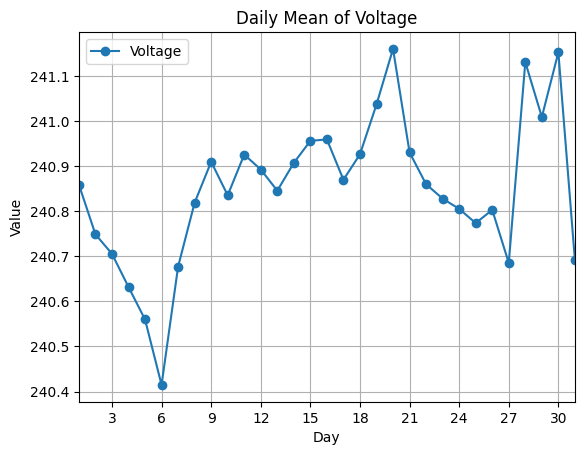

In [27]:
# Plots the average voltage feature trend over the years
df_daily = df.groupby(df.index.day).mean()

fig, ax = plt.subplots()

ax.plot(df_daily.index, df_daily['Voltage'], marker='o', label='Voltage')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Day')
ax.set_ylabel('Value')
ax.set_title('Daily Mean of Voltage')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

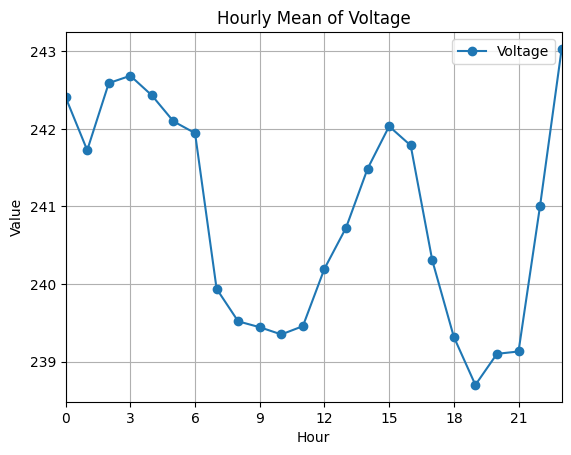

In [28]:
# Plots the average voltage feature trend over the years
df_hourly = df.groupby(df.index.hour).mean()

fig, ax = plt.subplots()

ax.plot(df_hourly.index, df_hourly['Voltage'], marker='o', label='Voltage')

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.set_xlabel('Hour')
ax.set_ylabel('Value')
ax.set_title('Hourly Mean of Voltage')
ax.grid(True)
ax.legend()

plt.margins(x=0)
plt.show()

### Complete Time Series for All Features

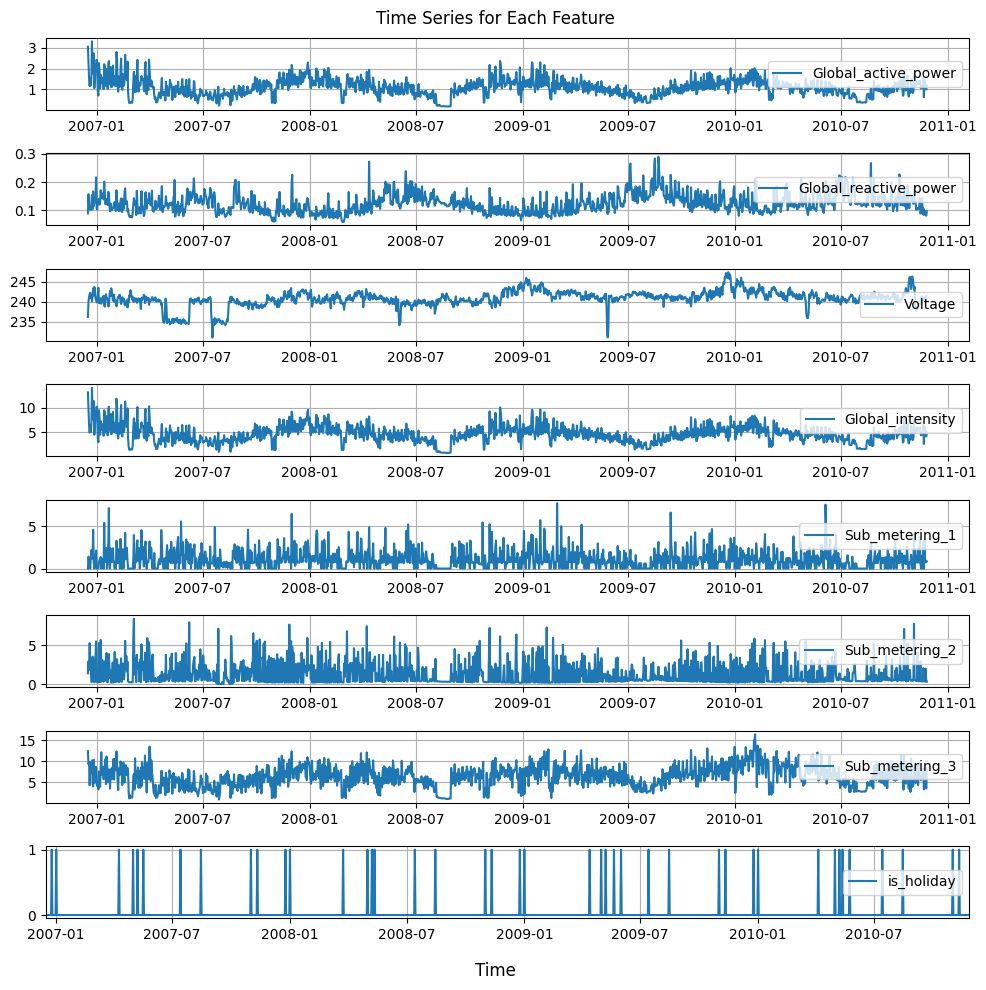

In [29]:
# Plots daily time series plot for each separately 
df_daily = df[features].resample('D').mean()

fig, ax = plt.subplots(8, figsize=(10, 10))
fig.suptitle('Time Series for Each Feature')
fig.supxlabel('Time')
for idx, col in enumerate(features):
    ax[idx].plot(df_daily.index, df_daily[col], label=col)
    ax[idx].legend(loc='right')
    ax[idx].grid(True)

plt.tight_layout()
plt.margins(x=0)
plt.show()


### Complete Calendar Heatmap for All Features

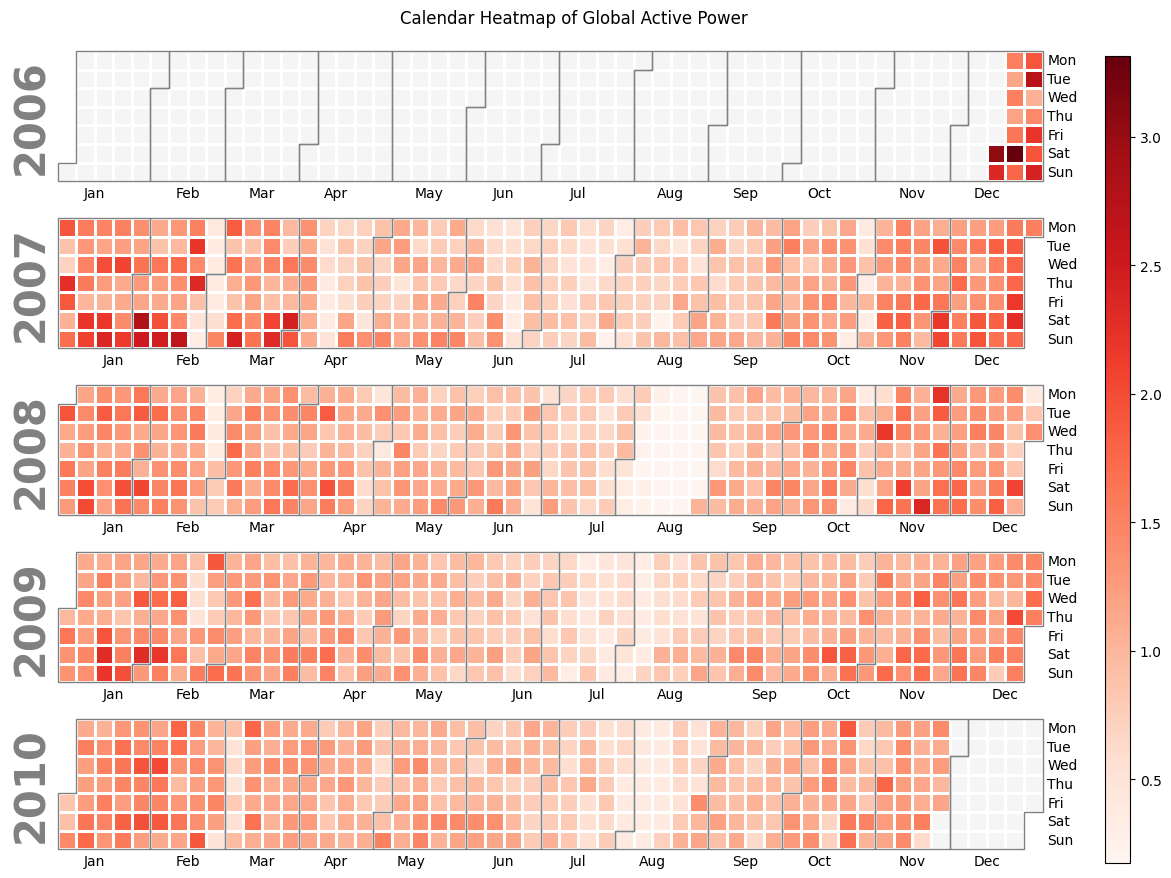

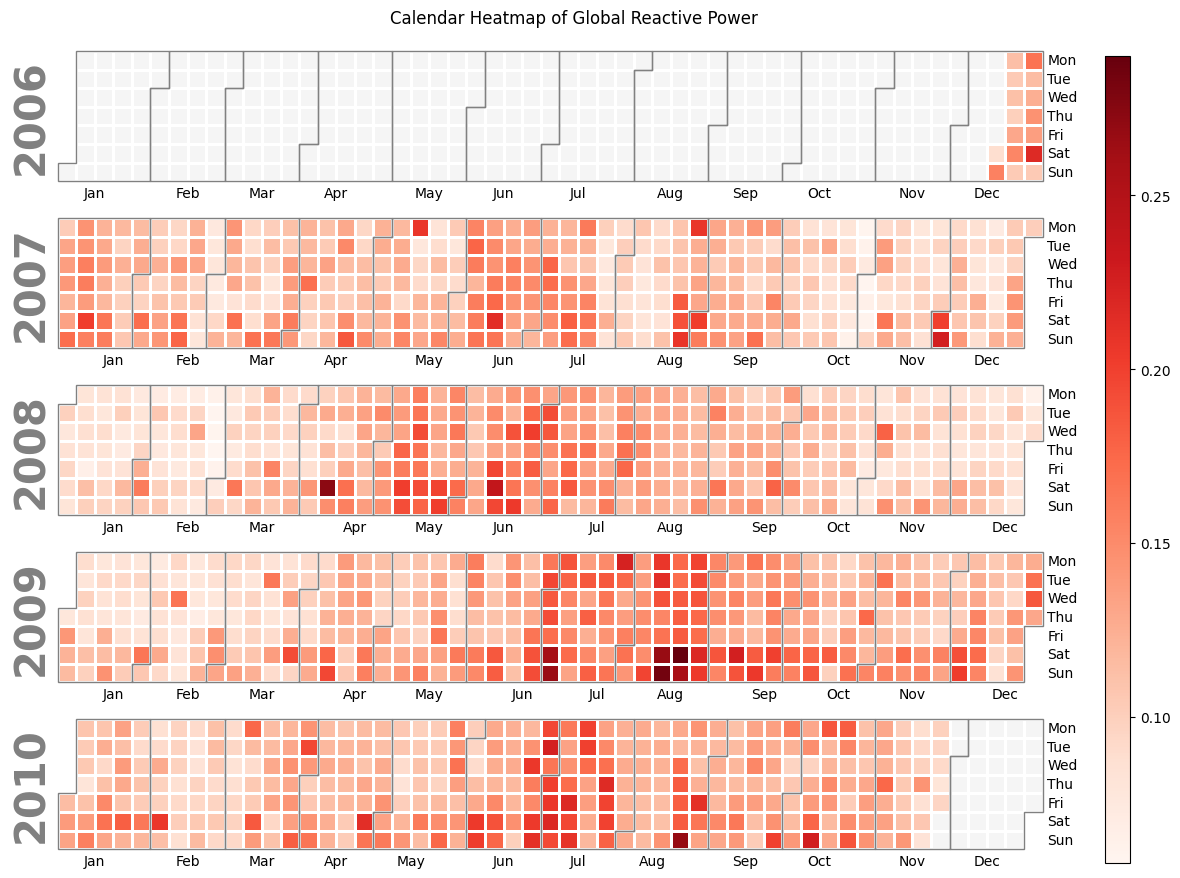

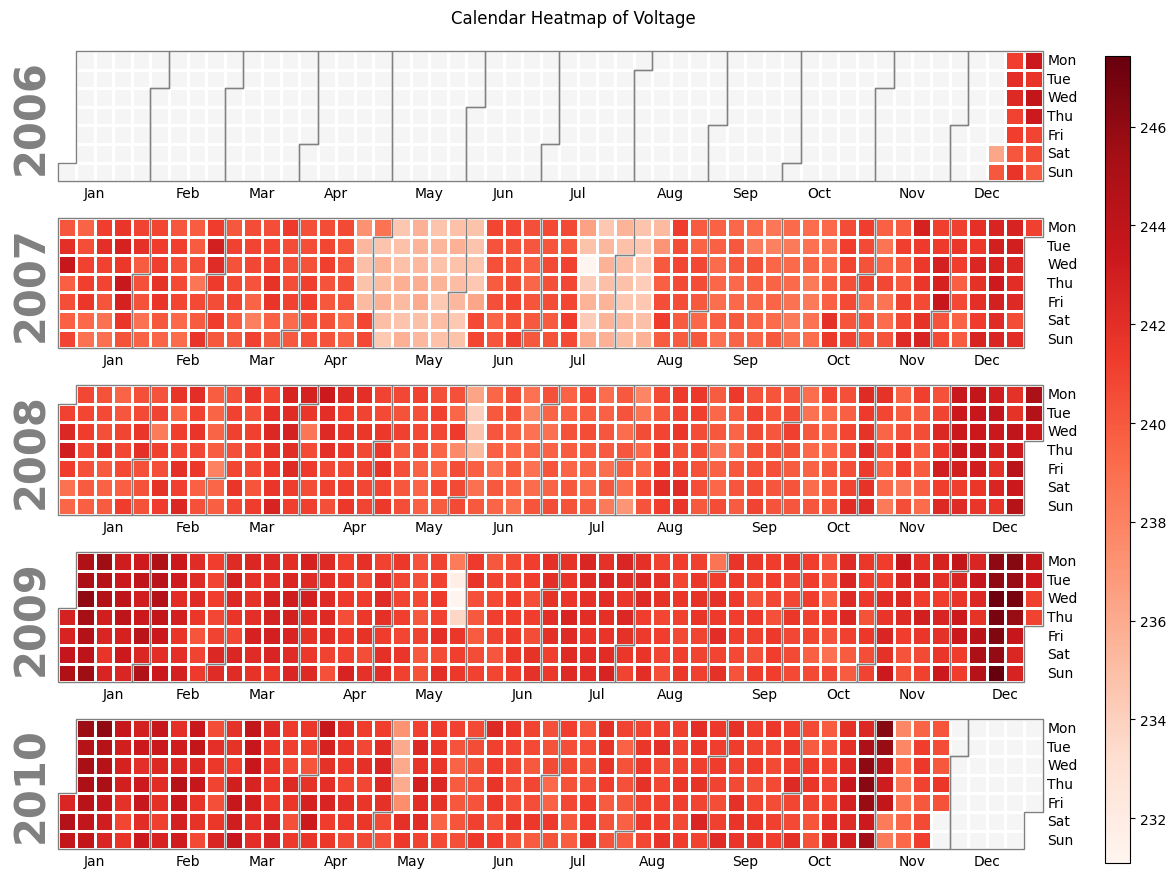

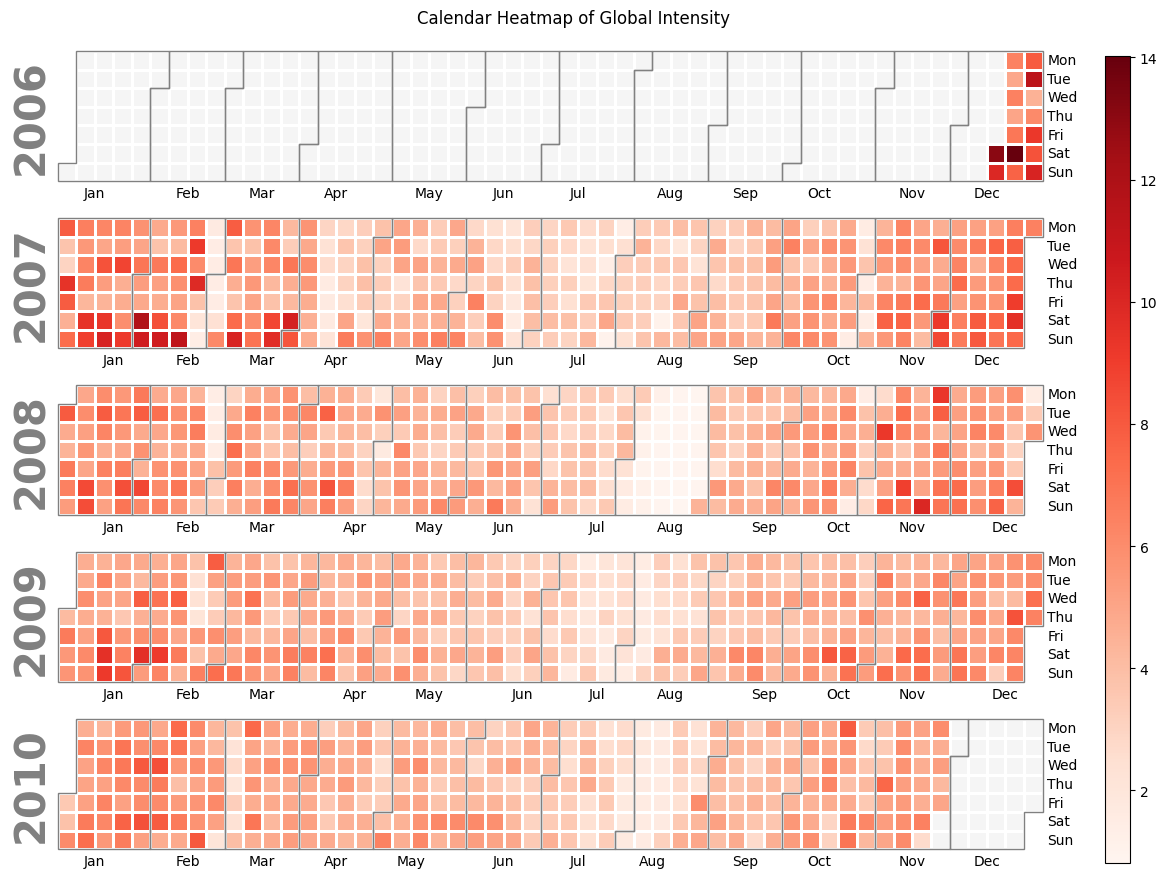

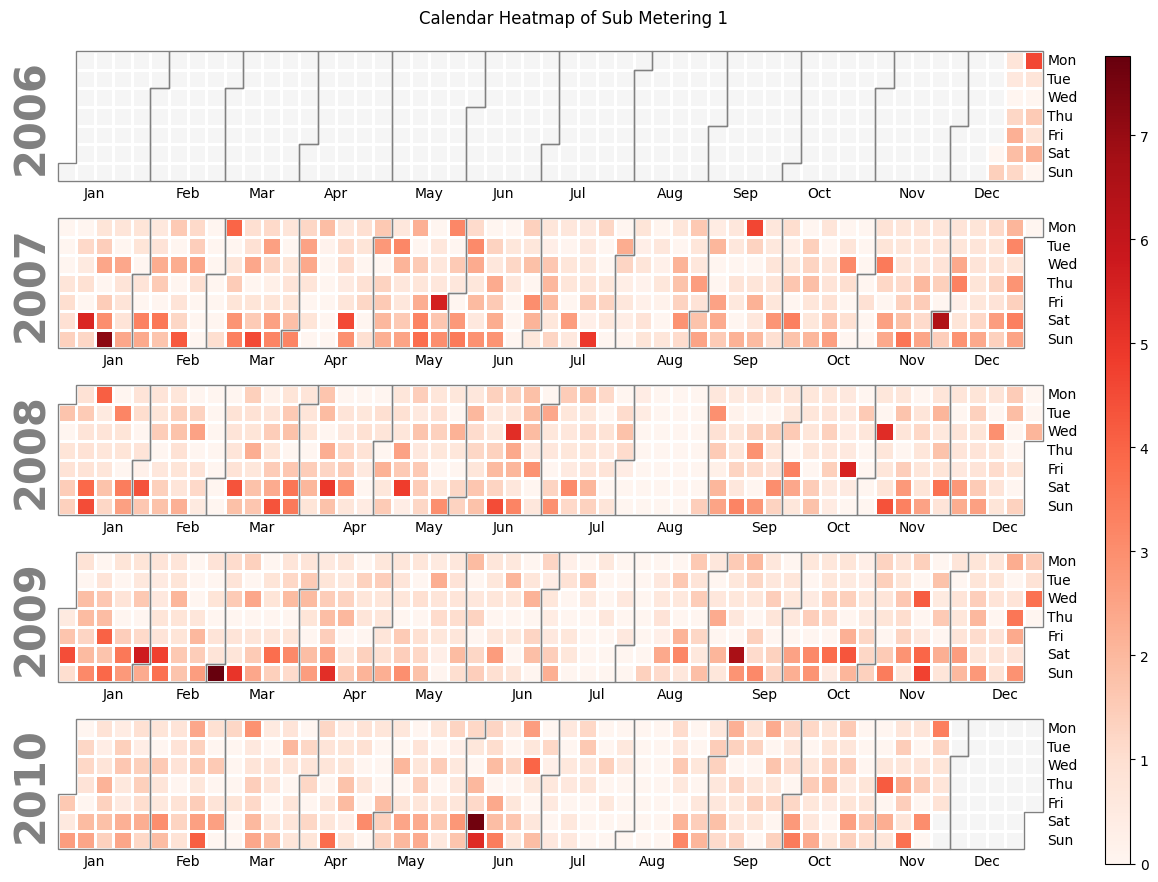

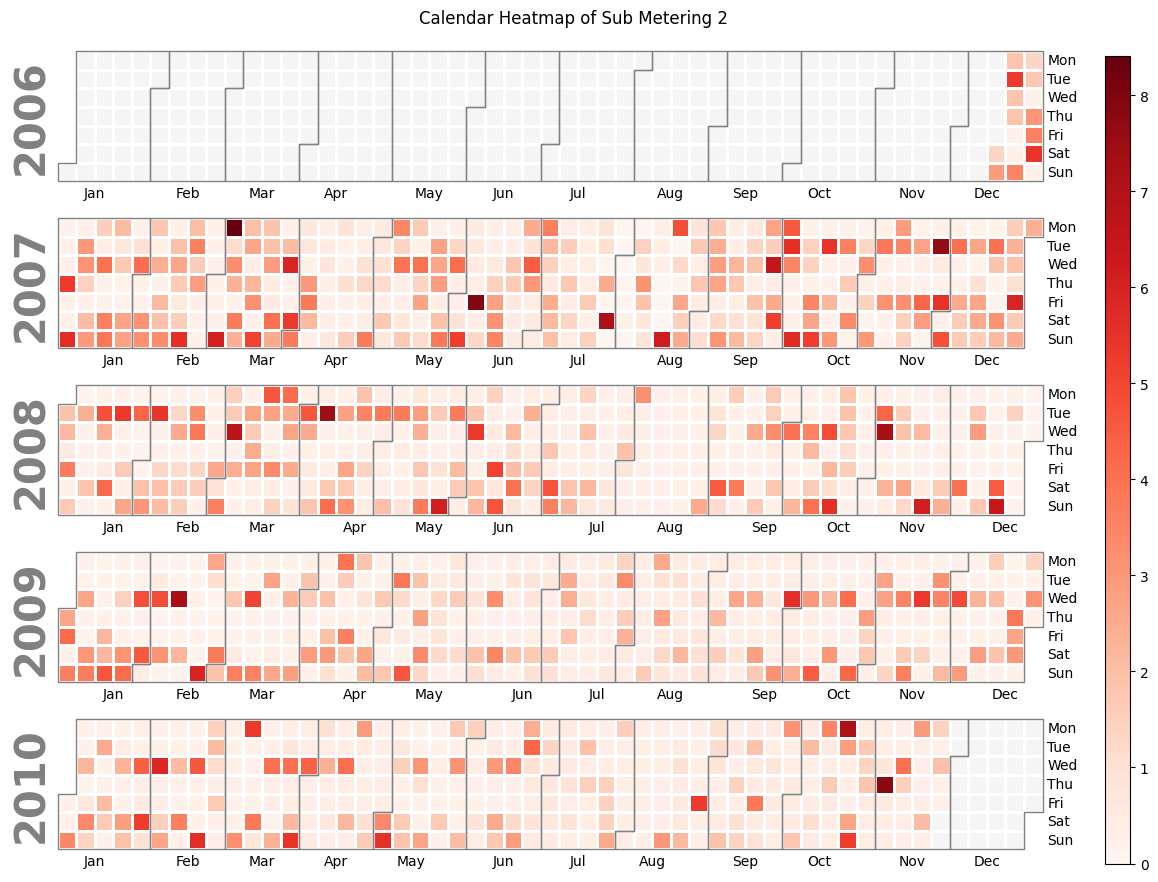

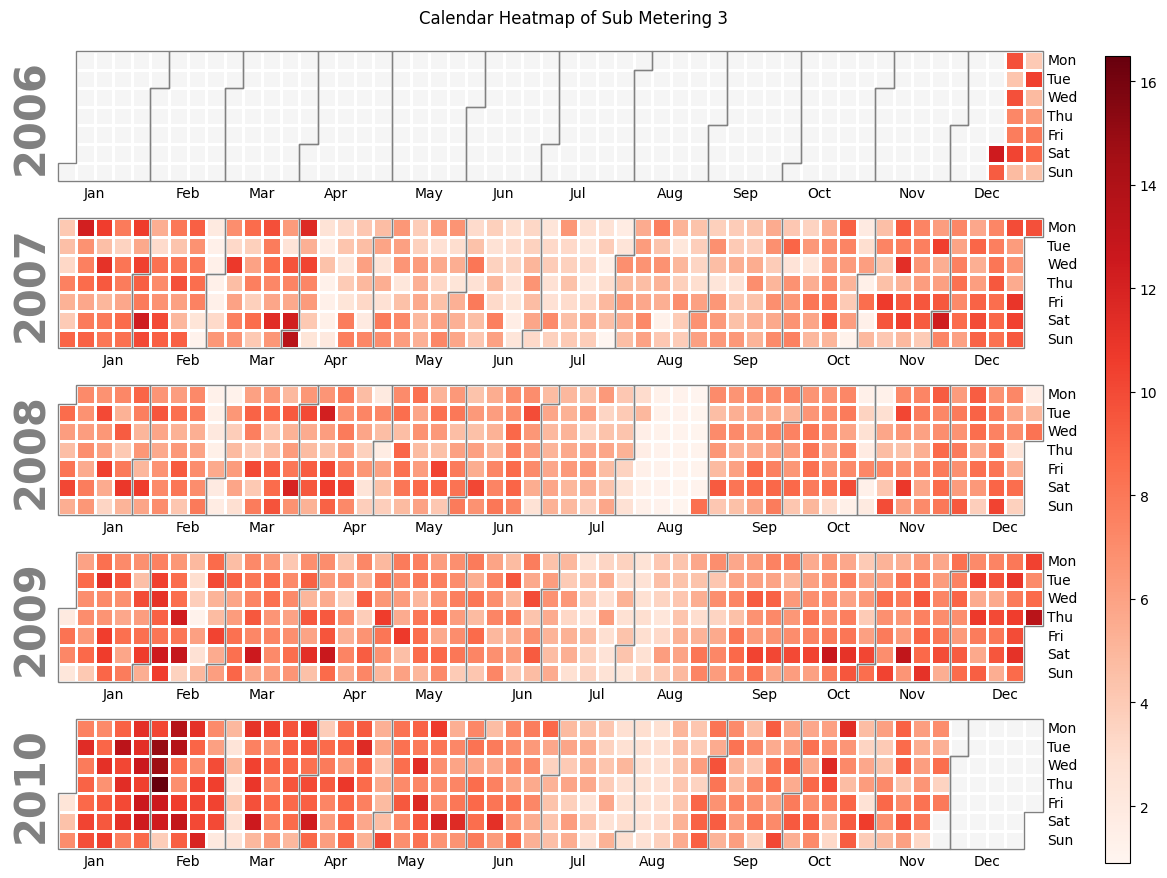

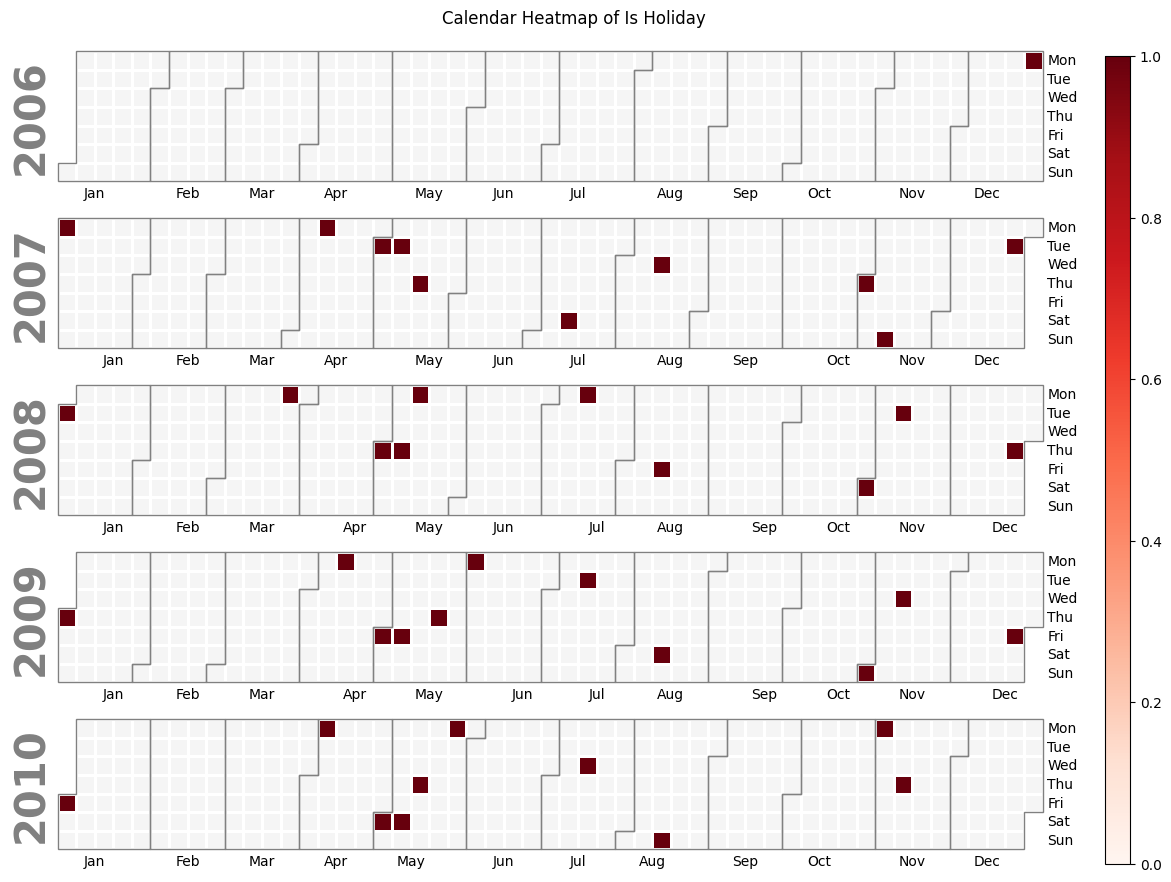

In [30]:
# Plots the heatmap for each feature for each day
plt.rcParams['font.family'] = 'DejaVu Sans'

df_daily = df.resample('D').mean()

for col in features:
    calplot.calplot(df_daily[col],
                    cmap='Reds',
                    colorbar=True,
                    suptitle=f'Calendar Heatmap of {format_column_name(col)}',
                    tight_layout=True,
                    vmin=df_daily[col].min(),
                    vmax=df_daily[col].max(),
                    yearlabel_kws={'fontname': 'sans-serif'})

    plt.show()

# Train Models

### Verify GPU Allocation

In [31]:
# Checks for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print('GPU found')
else:
    print('GPU is not allocated, using CPU as fallback')

GPU found


### Apply Standard Scalar on All Features

In [32]:
# Implement standardization after EDA to prevent sacled axis in plots
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df)

df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)

### Train Test Split

In [33]:
# Allocate 90% for training, 5% for validation, and 5% for testing
train_size = int(len(df) * TRAINING_RATIO)
validation_size = int(len(df) * VALIDATION_RATIO)

df_train = df[:train_size]
df_valid = df[train_size:train_size + validation_size]
df_test = df[train_size + validation_size:]

print(f'Train split size: {len(df_train)}')
print(f'Valid split size: {len(df_valid)}')
print(f'Test split size: {len(df_test)}')

Train split size: 1867733
Valid split size: 103762
Test split size: 103764


### Reshape Data

In [34]:
# Split the dataset by a window of the length of n as a new dimension and further split each data split into features and dependant variable
def sliding_window_sampler(df, steps=168):
    data = df.values
    N, F = data.shape
    out_len = N - steps

    shape = (out_len, steps, F)
    strides = (data.strides[0], data.strides[0], data.strides[1])
    x = as_strided(data, shape=shape, strides=strides)

    y = data[steps:, :7]

    return x, y


x_train, y_train = sliding_window_sampler(df_train, steps=SLIDING_WINDOW_SIZE)
x_valid, y_valid = sliding_window_sampler(df_valid, steps=SLIDING_WINDOW_SIZE)
x_test, y_test = sliding_window_sampler(df_test, steps=SLIDING_WINDOW_SIZE)

In [35]:
print(y_test.shape)

(103596, 7)


### Construct Model (Multi-Variate LSTM)

In [36]:
# Create a neural network that feature LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(LSTM_HIDDEN_NEURON_COUNT, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm.add(keras.layers.Dropout(LSTM_DROPOUT_P))
lstm.add(keras.layers.Dense(7, activation='linear'))
lstm.compile(loss='MeanSquaredError', metrics=['MAE'], optimizer='Adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               174400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 7)                 1407      
                                                                 
Total params: 175,807
Trainable params: 175,807
Non-trainable params: 0
_________________________________________________________________


### Construct Model (Multi-Variate Transformer)

In [37]:
# Create a neural network that feature Transformer with MHA
inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

x = keras.layers.MultiHeadAttention(num_heads=TRANSFORMER_NUMBER_OF_HEADS, key_dim=x_train.shape[2])(inputs, inputs)
x = keras.layers.Dropout(TRANSFORMER_DROPOUT_P)(x)
x = keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

x_ffn = keras.layers.Dense(TRANSFORMER_HIDDEN_NEURON_COUNT, activation='relu')(x)
x_ffn = keras.layers.Dense(x_train.shape[2])(x_ffn)
x_ffn = keras.layers.Dropout(TRANSFORMER_DROPOUT_P)(x_ffn)
x = keras.layers.LayerNormalization(epsilon=1e-6)(x + x_ffn)

x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(7, activation='linear')(x)

transformer = keras.models.Model(inputs=inputs, outputs=outputs)
transformer.compile(loss='MeanSquaredError', metrics=['MAE'], optimizer='Adam')
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 17)]    0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 168, 17)     4845        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 168, 17)      0           ['multi_head_attention[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 168, 17)     0           ['dropout_1[0][0]',          

### Create a Custom Data Generator

In [38]:
# Passes data as batches rather than upfront; mitigates OOM exceptions
class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        i = idx * self.batch_size
        return self.x[i:i + self.batch_size], self.y[i:i + self.batch_size]


train_gen = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
valid_gen = DataGenerator(x_valid, y_valid, batch_size=BATCH_SIZE)

### Fit Models

Training LSTM model
Epoch 1/100
1824/1824 [==============================] - 138s 75ms/step - loss: 0.1114 - MAE: 0.1636 - val_loss: 0.0579 - val_MAE: 0.1038
Epoch 2/100
1824/1824 [==============================] - 137s 75ms/step - loss: 0.0816 - MAE: 0.1330 - val_loss: 0.0555 - val_MAE: 0.1033
Epoch 3/100
1824/1824 [==============================] - 136s 75ms/step - loss: 0.0776 - MAE: 0.1307 - val_loss: 0.0530 - val_MAE: 0.1053
Epoch 4/100
1824/1824 [==============================] - 138s 75ms/step - loss: 0.0749 - MAE: 0.1291 - val_loss: 0.0507 - val_MAE: 0.0998
Epoch 5/100
1824/1824 [==============================] - 139s 76ms/step - loss: 0.0728 - MAE: 0.1273 - val_loss: 0.0492 - val_MAE: 0.1054
Epoch 6/100
1824/1824 [==============================] - 140s 77ms/step - loss: 0.0710 - MAE: 0.1260 - val_loss: 0.0488 - val_MAE: 0.0962
Epoch 7/100
1824/1824 [==============================] - 144s 79ms/step - loss: 0.0695 - MAE: 0.1249 - val_loss: 0.0469 - val_MAE: 0.0955
Epoch 8/100
18

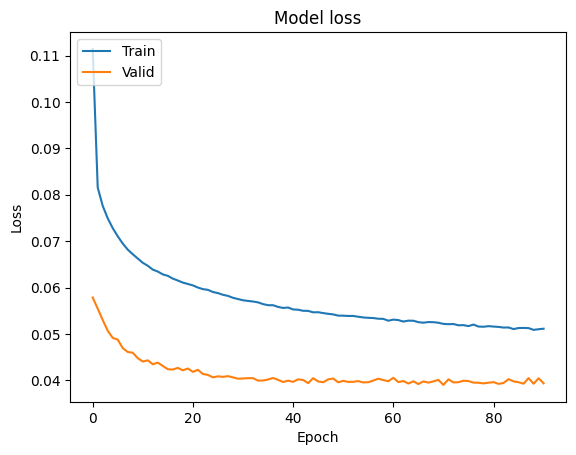


Training transformer model
Epoch 1/100
1824/1824 [==============================] - 139s 76ms/step - loss: 0.6077 - MAE: 0.4591 - val_loss: 0.3214 - val_MAE: 0.3231
Epoch 2/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.3484 - MAE: 0.3126 - val_loss: 0.2610 - val_MAE: 0.2801
Epoch 3/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.2988 - MAE: 0.2817 - val_loss: 0.2360 - val_MAE: 0.2654
Epoch 4/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.2403 - MAE: 0.2550 - val_loss: 0.1796 - val_MAE: 0.2377
Epoch 5/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.1930 - MAE: 0.2259 - val_loss: 0.1465 - val_MAE: 0.2054
Epoch 6/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.1693 - MAE: 0.2091 - val_loss: 0.1292 - val_MAE: 0.1898
Epoch 7/100
1824/1824 [==============================] - 138s 76ms/step - loss: 0.1519 - MAE: 0.1962 - val_loss: 0.1172 - val_MAE: 0.1869
Epoch 

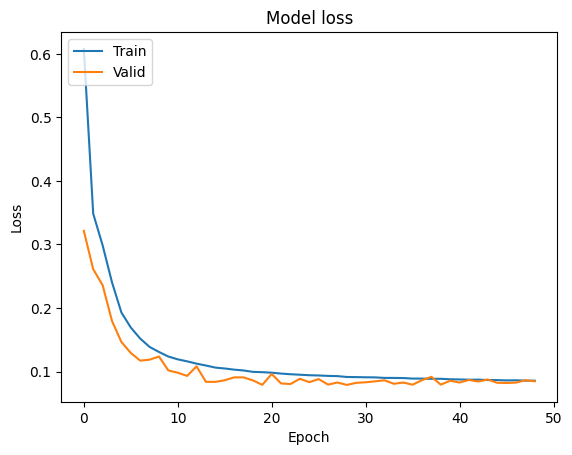

In [39]:
# Train the model with early stopping
def train_model(model, name) -> None:
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE)
    history = model.fit(train_gen, validation_data=valid_gen, epochs=NUMBER_OF_EPOCHS, callbacks=[callback])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    model.save(f'./assets/models/{name}-{time.time_ns() // 1_000_000_000}.h5')
    return model


print('Training LSTM model')
print('==============================')
model_lstm = train_model(lstm, 'lstm')
print()
print('Training transformer model')
print('==============================')
model_transformer = train_model(transformer, 'transformer')

# Evaluate Model

In [40]:
output_features = [x for x in df.columns if x not in temporal_features and x != 'is_holiday']

In [41]:
# Mimics the implementation of scikit-learn's inverse_transform for the standard scalar, without the restriction of matching the exact number of features
def inverse_transform(df_scaled, scaler, column_indices):
    scale = scaler.scale_[column_indices]
    mean = scaler.mean_[column_indices]
    return df_scaled * scale + mean

In [42]:
# Calculate the evaluation metric of the model with respect of the testing set
def predict(model):
    expected_values = model.predict(x_test)

    df_expected = pd.DataFrame(expected_values, columns=output_features, index=df_test.index[-len(y_test):])
    df_actual = pd.DataFrame(y_test, columns=output_features, index=df_test.index[-len(y_test):])

    df_expected = inverse_transform(df_expected, scaler, list(range(7)))
    df_actual = inverse_transform(df_actual, scaler, list(range(7)))

    def eval(idx):
        return {
            'MSE': sklearn.metrics.mean_squared_error(df_actual.iloc[:, idx], df_expected.iloc[:, idx]),
            'MAE': sklearn.metrics.mean_absolute_error(df_actual.iloc[:, idx], df_expected.iloc[:, idx]),
            'R2': sklearn.metrics.r2_score(df_actual.iloc[:, idx], df_expected.iloc[:, idx]),
        }

    results = dict()

    for idx, item in enumerate(df_expected.columns):
        results[format_column_name(item)] = eval(idx)

    return df_expected, df_actual, results


df_expected_lstm, df_actual, results_lstm = predict(model_lstm)
df_expected_transformer, _, results_transformer = predict(model_transformer)

3238/3238 [==============================] - 11s 4ms/step


In [43]:
print('LSTM')
print(tabulate(pd.DataFrame(results_lstm), headers='keys', tablefmt='psql'))
print('Transformer')
print(tabulate(pd.DataFrame(results_transformer), headers='keys', tablefmt='psql'))

LSTM
+-----+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------+
|     |   Global Active Power |   Global Reactive Power |   Voltage |   Global Intensity |   Sub Metering 1 |   Sub Metering 2 |   Sub Metering 3 |
|-----+-----------------------+-------------------------+-----------+--------------------+------------------+------------------+------------------|
| MSE |             0.0400364 |               0.0018144 |  0.353852 |           0.752957 |         2.52786  |         1.78328  |         2.12156  |
| MAE |             0.0832064 |               0.0234545 |  0.440743 |           0.375582 |         0.303174 |         0.371407 |         0.660462 |
| R2  |             0.956642  |               0.861756  |  0.969213 |           0.954293 |         0.927462 |         0.93541  |         0.971564 |
+-----+-----------------------+-------------------------+-----------+--------------------+-----------------

# Results Interpretation

### Residual Plot

In [44]:
# Plots the residual plot of each feature while applying Gaussian KDE when applicable
def residual_plot(df_expected, df_actual):
    for idx, item in enumerate(df_expected.columns):
        expected = df_expected.iloc[:, idx]
        actual = df_actual.iloc[:, idx]

        diff = [y - x for x, y in zip(expected, actual)]
        x, y = zip(*sorted(zip(expected, diff)))
        trend_coeffs = np.polyfit(x, y, 1)
        trend_line = np.poly1d(trend_coeffs)(x)
        if actual.any():
            densities = gaussian_kde(np.vstack([y, x]))(np.vstack([y, x]))
            cmap = 'coolwarm'
        else:
            print('Could not compute the Gaussian KDE; truth label might have a variance of zero')
            densities = None
            cmap = None

        plt.figure(figsize=(8, 6))
        plot = plt.scatter(x, y, c=densities, s=25, cmap=cmap, label='_nolegend_')
        plt.axhline(y=0, color='b', linestyle='--')
        plt.plot(x, trend_line, color='g', linestyle='--')

        plt.title(f'Residual Plot for {format_column_name(item)} Feature')
        plt.xlabel('Expected')
        plt.ylabel('Residuals')
        plt.legend(['Origin', 'Trend Line'])
        if densities is not None:
            plt.colorbar(plot)
        plt.margins(x=0)
        plt.ticklabel_format(useOffset=False)
        plt.show()

### Power Time-Series Forcasting

In [45]:
# Resample on daily-basis rather than second-basis to prevent excessive fluctuations in the plots
df_expected_daily_lstm = df_expected_lstm.resample('D').mean()
df_actual_daily_lstm = df_actual.resample('D').mean()

df_expected_daily_transformer = df_expected_transformer.resample('D').mean()
df_actual_daily_transformer = df_actual.resample('D').mean()

In [46]:
# Applying forcasting of the model on the power features by subsampling the last n records of the testing set
def forecast_power(df_expected_daily, df_actual_daily):
    fig, ax = plt.subplots(figsize=(10, 6))

    highlight_start = int(len(df_actual_daily) * 0.8)
    highlight_end = len(df_actual_daily) - 1

    colors = plt.get_cmap('tab10').colors
    for i, column in enumerate(power_features):
        color = colors[i]
        plt.plot(df_expected_daily[column], label=f'Expected {format_column_name(column)}', linestyle='--', color=color)
        plt.plot(df_actual_daily[column][:highlight_start], label=f'Actual {format_column_name(column)}', color=color)
    plt.axvspan(df_expected_daily.index[highlight_start], df_expected_daily.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

    plt.title('Multivariate Time-Series Forecasting')
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()
    plt.margins(x=0)
    plt.show()

### Voltage Time-Series Forcasting

In [47]:
# Applying forcasting of the model on the voltage features by subsampling the last n records of the testing set
def forecast_voltage(df_expected_daily, df_actual_daily):
    fig, ax = plt.subplots(figsize=(10, 6))

    highlight_start = int(len(df_actual_daily) * 0.8)
    highlight_end = len(df_actual_daily) - 1

    plt.plot(df_expected_daily['Voltage'], label=f'Expected {format_column_name("Voltage")}', linestyle='--')
    plt.plot(df_actual_daily['Voltage'][:highlight_start], label=f'Actual {format_column_name("Voltage")}')
    plt.axvspan(df_expected_daily.index[highlight_start], df_expected_daily.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

    plt.title('Multivariate Time-Series Forecasting')
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()
    plt.margins(x=0)
    plt.show()

### Time-series Forcasting With Uncertainty

##### Apply Monte Carlo Principal for Randomness

In [48]:
# Predict the samples while disabling neurons during inference
def apply_monte_carlo(model, x_test, y_test, batch_size=1024):
    def mc_dropout(model, x, n=50):
        all_preds = []

        for _ in range(n):
            preds = []
            for x_batch in x:
                out = model(x_batch[0], training=True).numpy()
                preds.append(out)
            preds = np.concatenate(preds, axis=0)
            all_preds.append(preds)

        all_preds = np.stack(all_preds)
        all_preds = inverse_transform(all_preds, scaler, list(range(7)))
        
        return all_preds.mean(axis=0), all_preds.std(axis=0)

    test_gen = DataGenerator(x_test, y_test, batch_size=batch_size)
    expected_mean, expected_std = mc_dropout(model, test_gen)

    df_expected_mean = pd.DataFrame(expected_mean, columns=output_features, index=df_test.index[-len(y_test):])
    df_expected_std = pd.DataFrame(expected_std, columns=output_features, index=df_test.index[-len(y_test):])
    df_actual = pd.DataFrame(y_test, columns=output_features, index=df_test.index[-len(y_test):])

    df_expected_mean_daily = df_expected_mean.resample('D').mean()
    df_expected_std_daily = df_expected_std.resample('D').mean()

    return df_expected_mean_daily, df_expected_std_daily


df_expected_mean_daily_lstm, df_expected_std_daily_lstm = apply_monte_carlo(lstm, x_test, y_test, batch_size=math.ceil(BATCH_SIZE / 2))
df_expected_mean_daily_transformer, df_expected_std_daily_transformer = apply_monte_carlo(transformer, x_test, y_test, batch_size=math.ceil(BATCH_SIZE / 2))

##### Power Time-series Forcasting With Uncertainty

In [49]:
# Applying forcasting of the model on the power features by subsampling the last n records of the testing set
def forecast_power_with_uncertainty(df_expected_mean_daily, df_expected_std_daily, df_actual_daily):
    highlight_start = int(len(df_actual_daily) * 0.8)
    highlight_end = len(df_actual_daily) - 1

    for i, column in enumerate(power_features):
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.plot(df_expected_mean_daily[column], label=f'Expected {format_column_name(column)}', linestyle='--')
        plt.fill_between(df_expected_mean_daily.index, df_expected_mean_daily[column] - df_expected_std_daily[column], df_expected_mean_daily[column] + df_expected_std_daily[column], color='b', alpha=0.2)
        plt.plot(df_actual_daily[column][:highlight_start], label=f'Actual {format_column_name(column)}')
        plt.axvspan(df_actual_daily.index[highlight_start], df_actual_daily.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

        plt.title('Multivariate Time-Series Forecasting With Uncertainty')
        plt.xlabel('Dates')
        plt.ylabel('Values')
        plt.legend()
        plt.margins(x=0)
        plt.show()

##### Voltage Time-series Forcasting With Uncertainty

In [50]:
# Applying forcasting of the model on the voltage features by subsampling the last n records of the testing set
def forecast_voltage_with_uncertainty(df_expected_mean_daily, df_expected_std_daily, df_actual_daily):
    fig, ax = plt.subplots(figsize=(10, 6))

    highlight_start = int(len(df_actual_daily) * 0.8)
    highlight_end = len(df_actual_daily) - 1

    plt.plot(df_expected_mean_daily['Voltage'], label=f'Expected {format_column_name("Voltage")}', linestyle='--')
    plt.fill_between(df_expected_mean_daily.index, df_expected_mean_daily['Voltage'] - df_expected_std_daily['Voltage'], df_expected_mean_daily['Voltage'] + df_expected_std_daily['Voltage'], color='b', alpha=0.2)
    plt.plot(df_actual_daily['Voltage'][:highlight_start], label=f'Actual {format_column_name("Voltage")}')
    plt.axvspan(df_actual_daily.index[highlight_start], df_actual_daily.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

    plt.title('Multivariate Time-Series Forecasting With Uncertainty')
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()
    plt.margins(x=0)
    plt.show()

### LSTM Model Results Interpretation

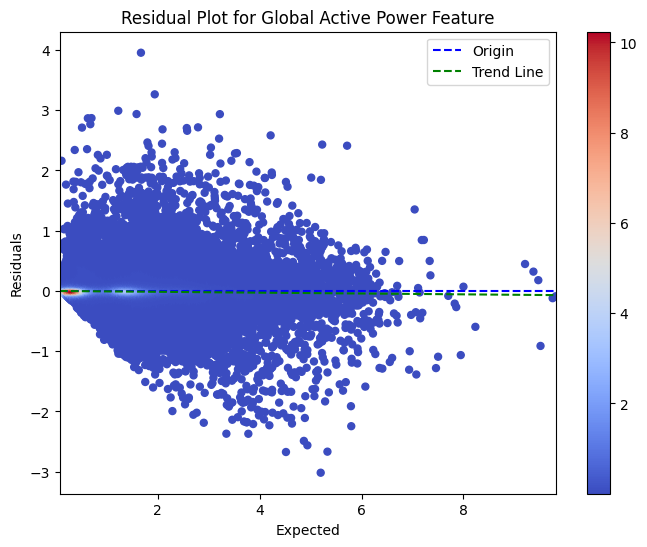

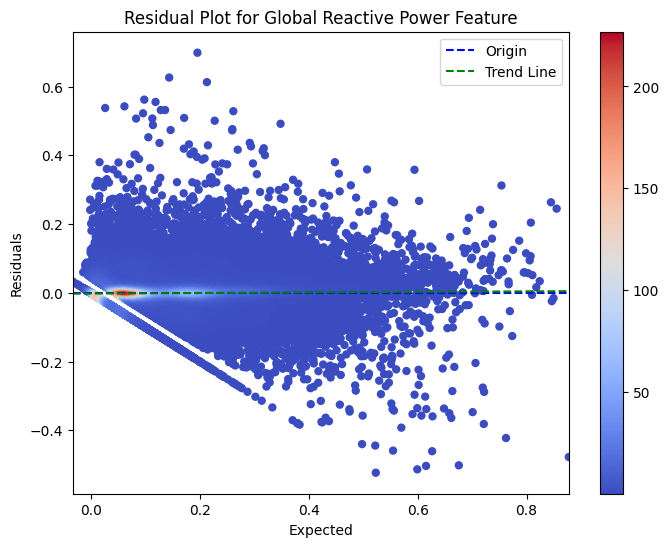

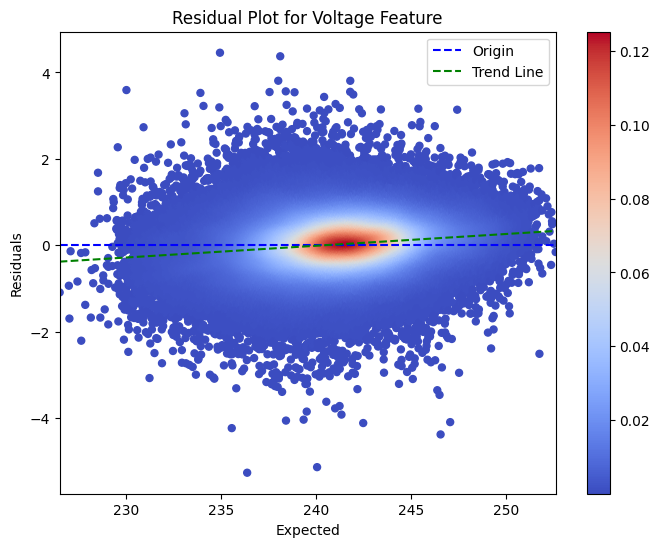

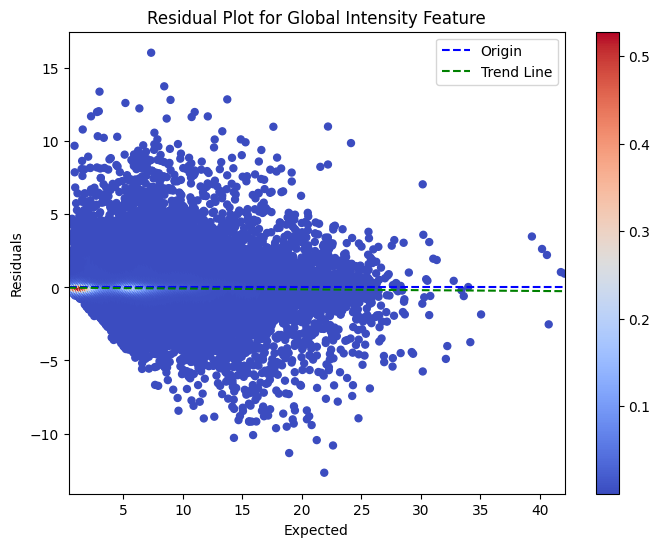

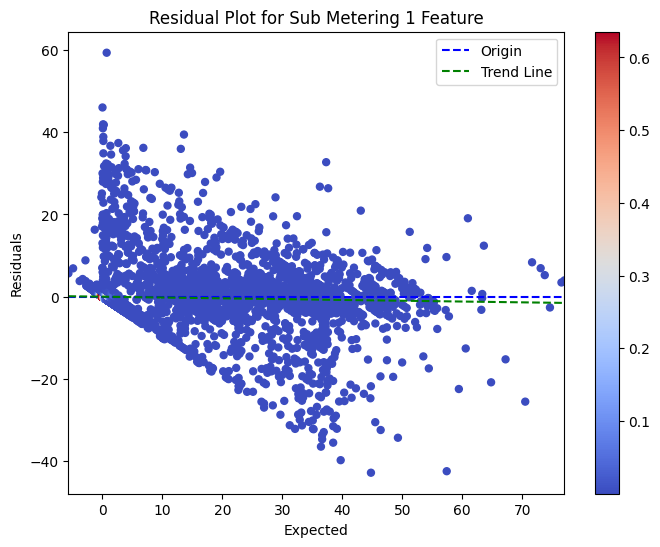

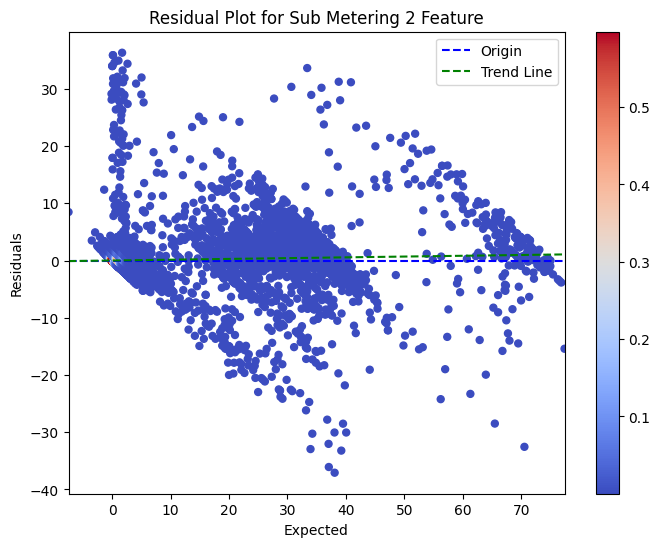

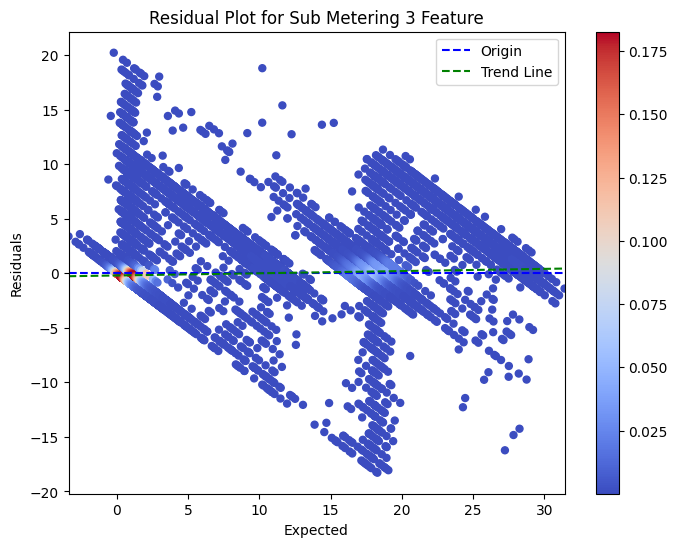

In [51]:
residual_plot(df_expected_lstm, df_actual)

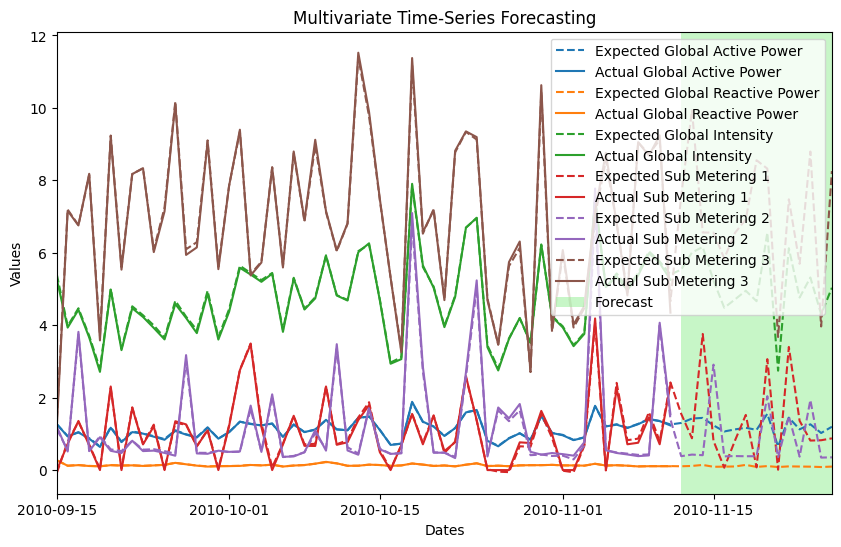

In [52]:
forecast_power(df_expected_daily_lstm, df_actual_daily_lstm)

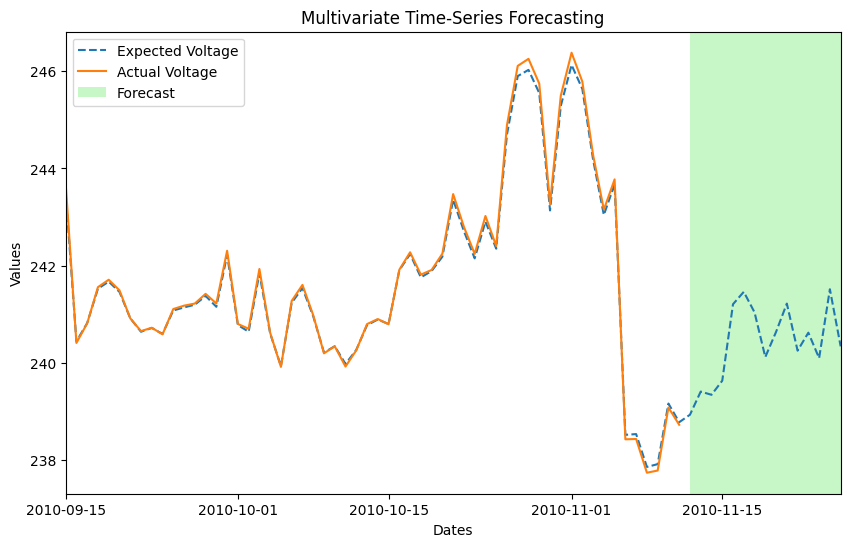

In [53]:
forecast_voltage(df_expected_daily_lstm, df_actual_daily_lstm)

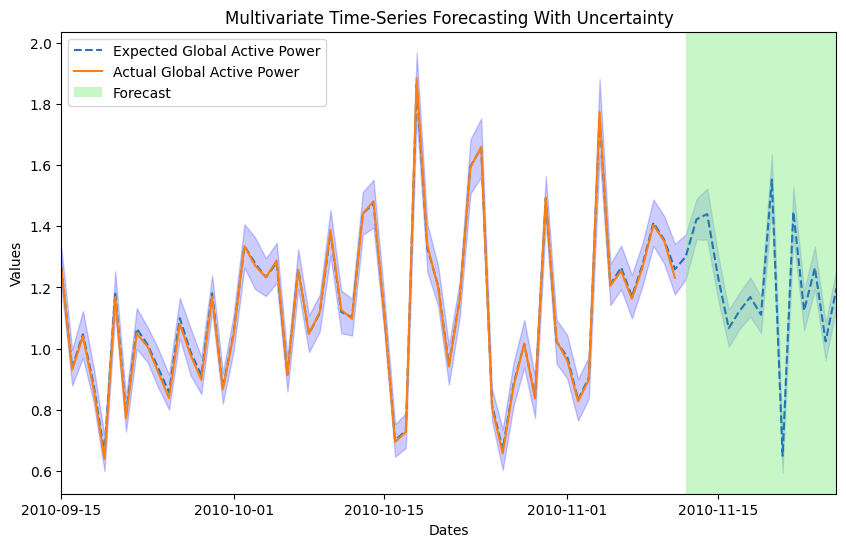

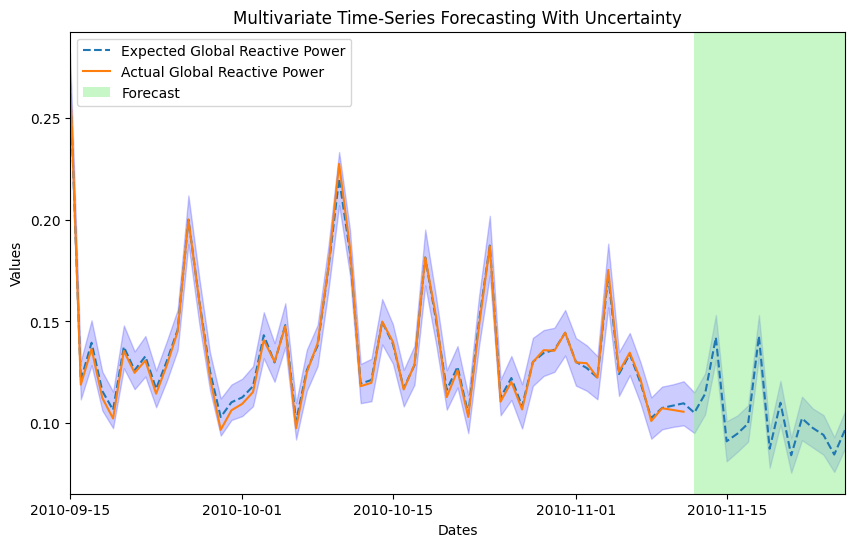

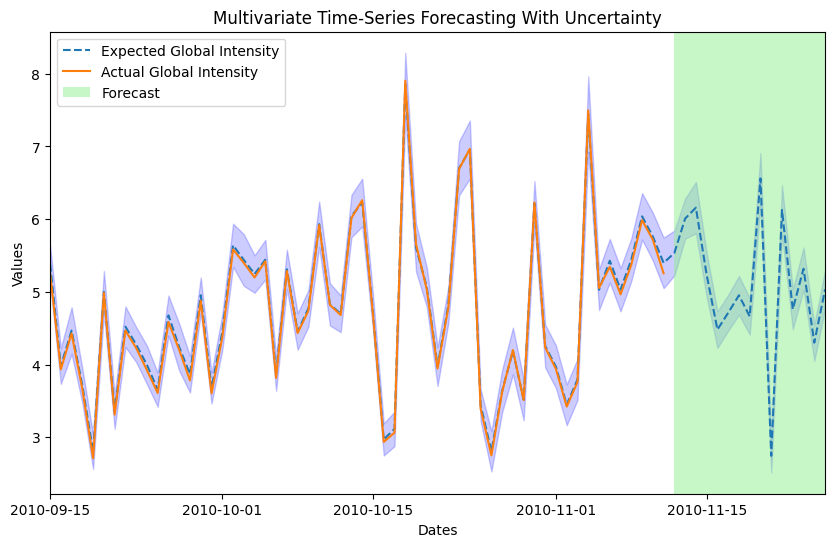

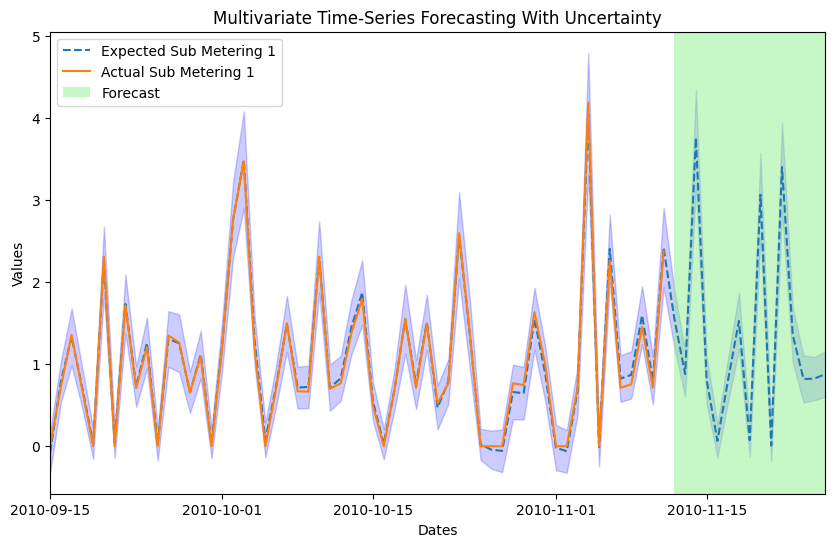

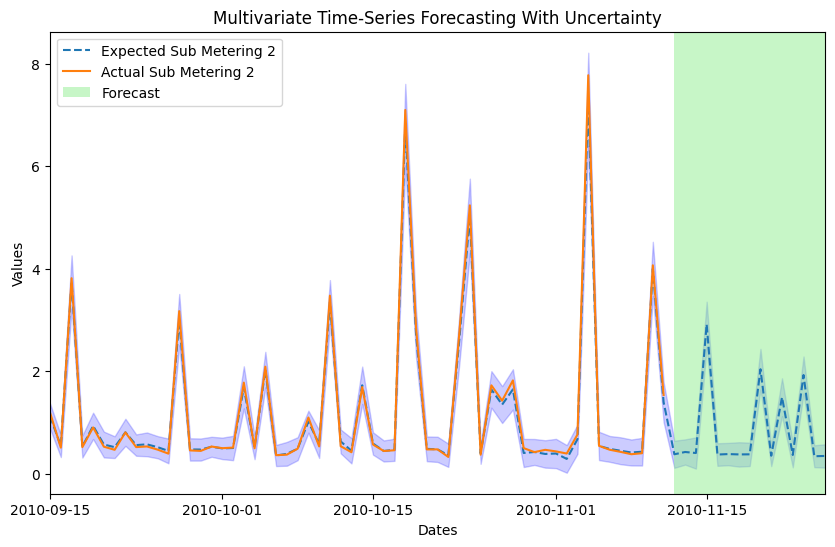

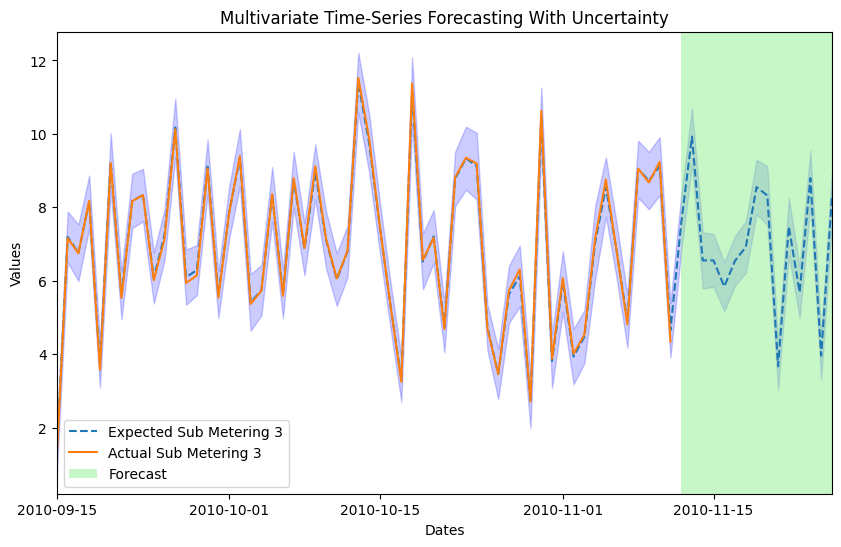

In [54]:
forecast_power_with_uncertainty(df_expected_mean_daily_lstm, df_expected_std_daily_lstm, df_actual_daily_lstm)

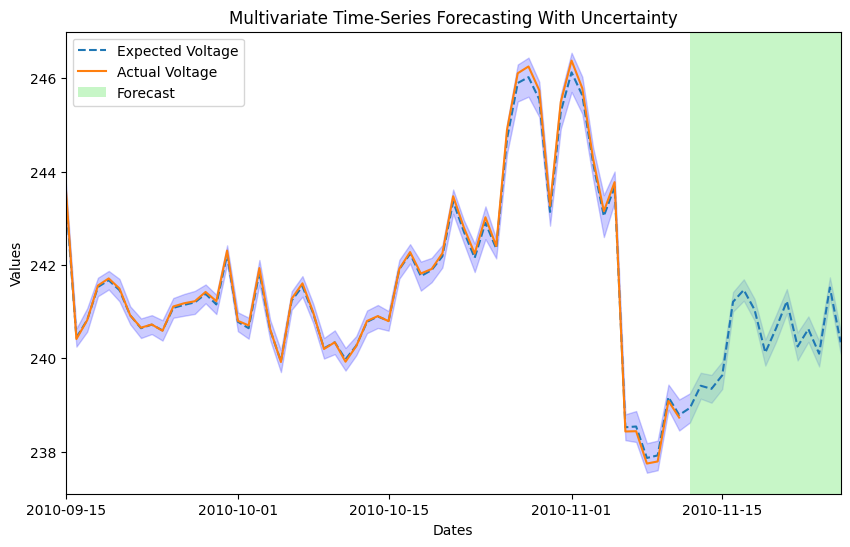

In [55]:
forecast_voltage_with_uncertainty(df_expected_mean_daily_lstm, df_expected_std_daily_lstm, df_actual_daily_lstm)

### Transformer Model Results Interpretation

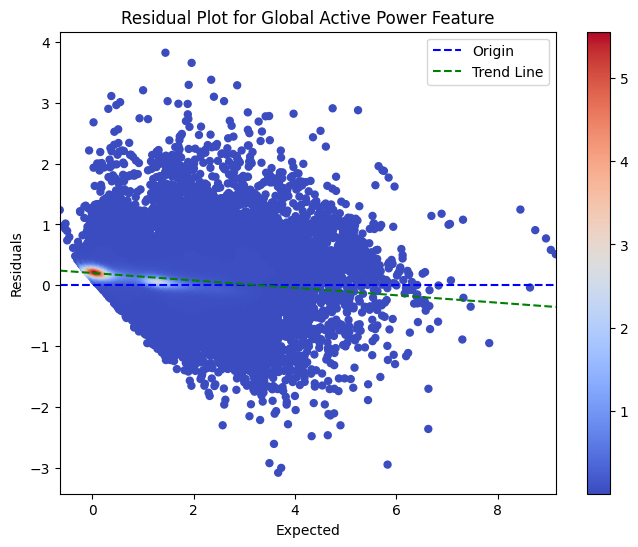

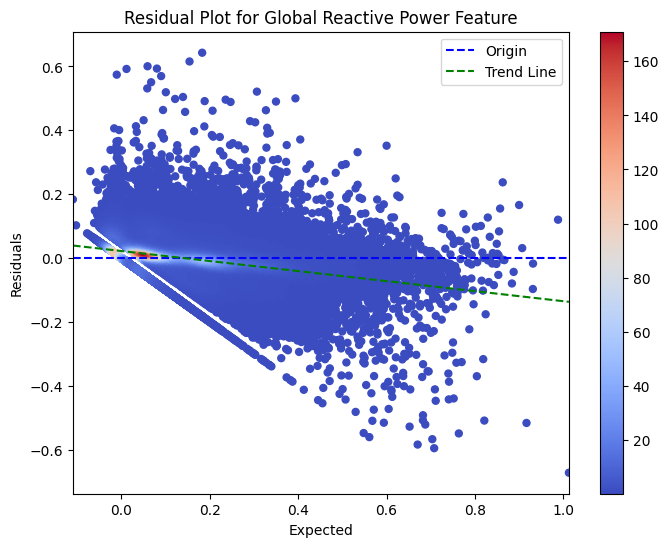

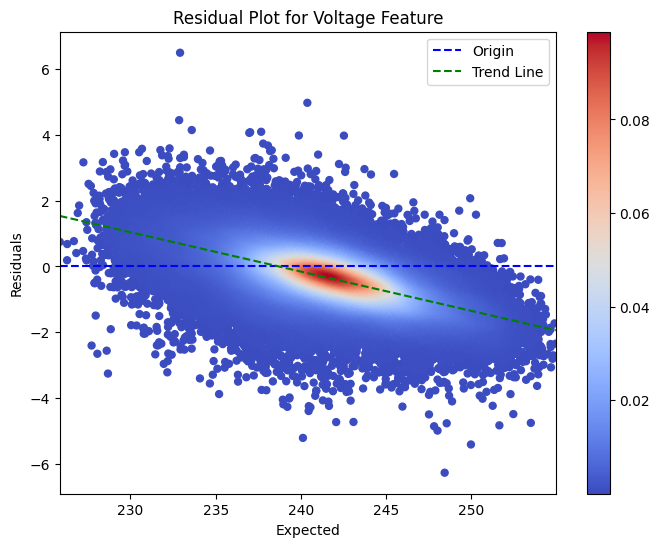

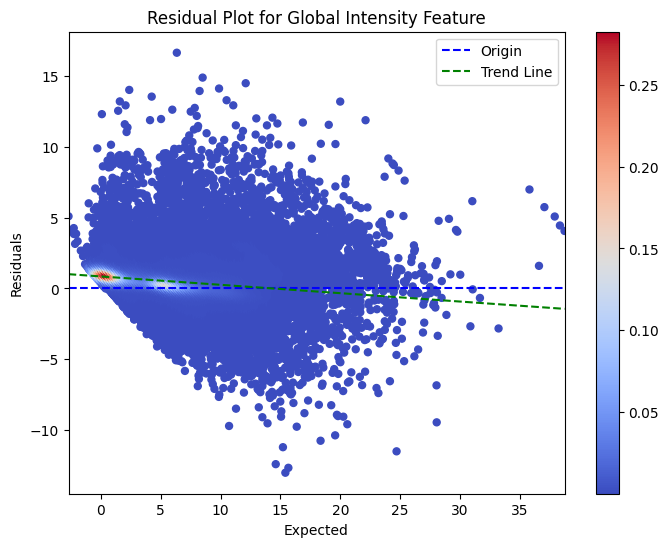

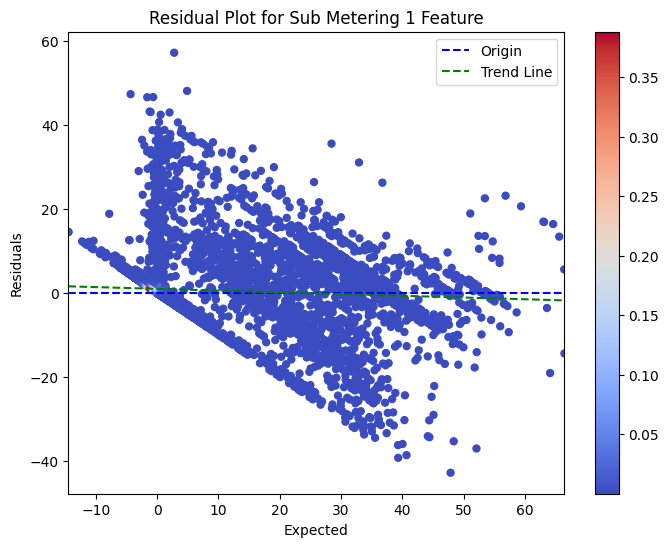

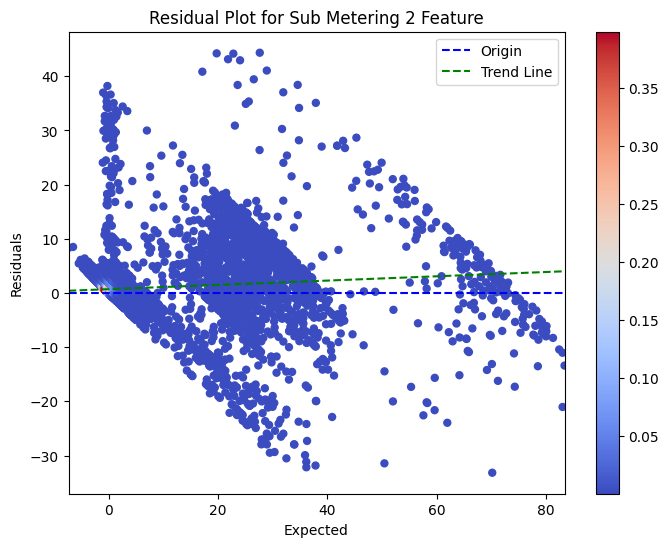

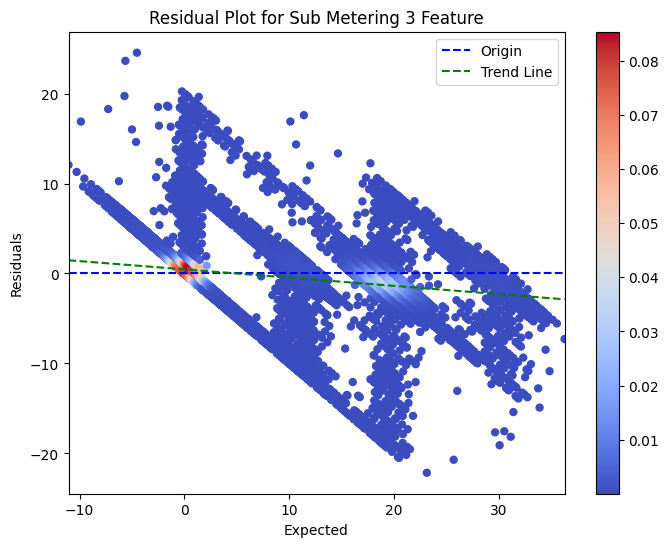

In [56]:
residual_plot(df_expected_transformer, df_actual)

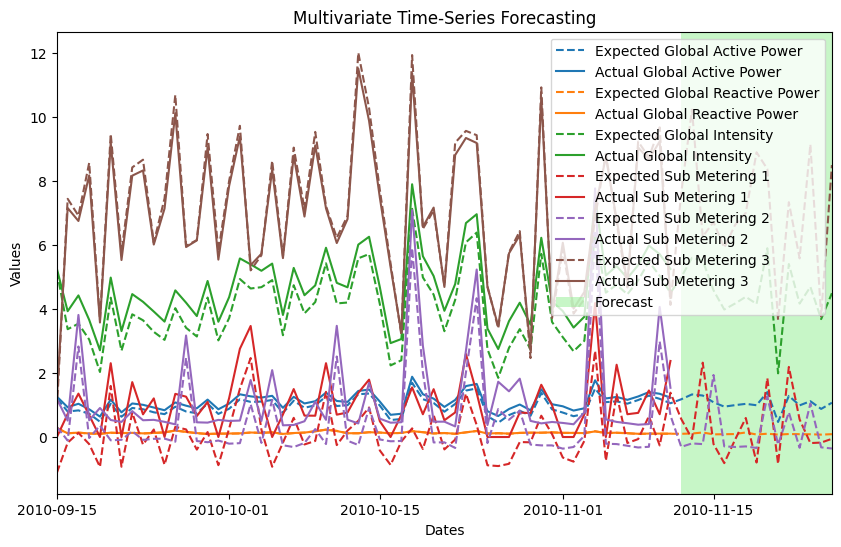

In [57]:
forecast_power(df_expected_daily_transformer, df_actual_daily_transformer)

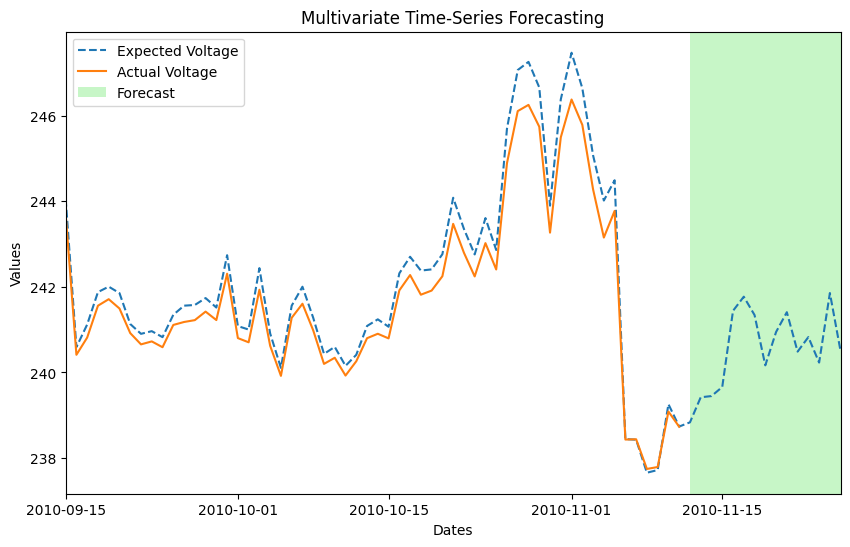

In [58]:
forecast_voltage(df_expected_daily_transformer, df_actual_daily_transformer)

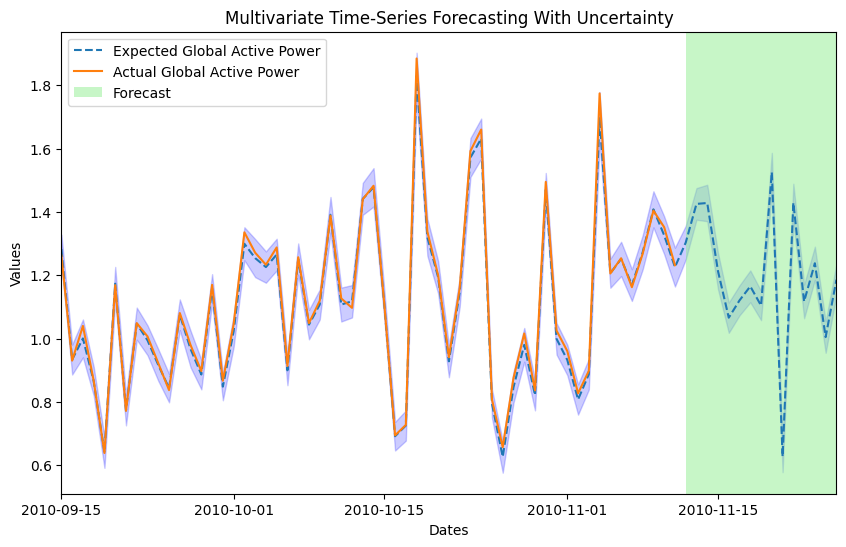

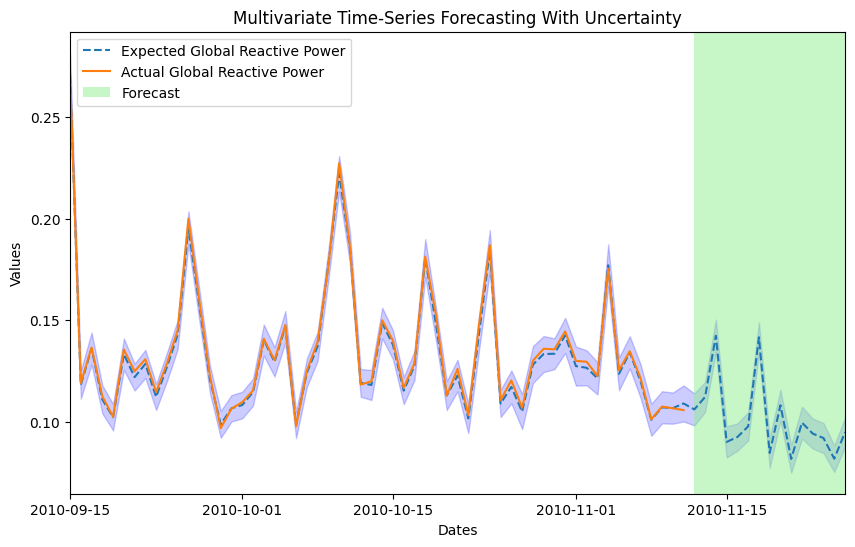

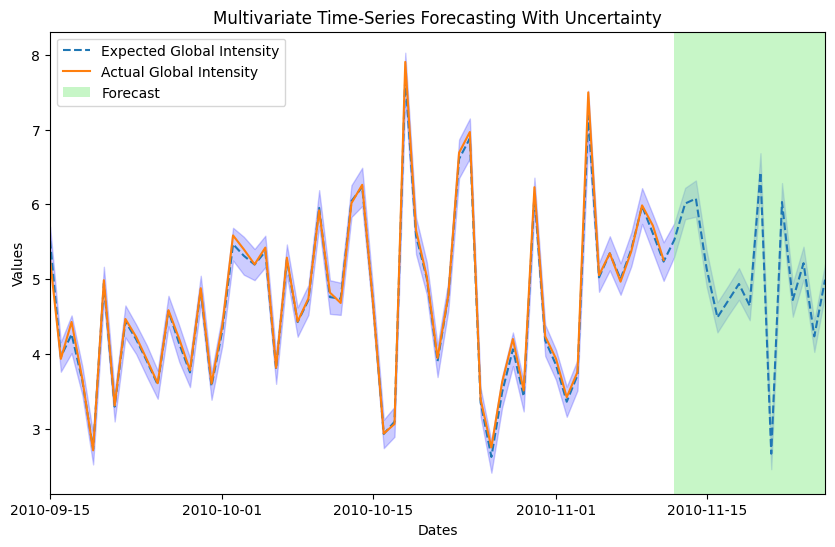

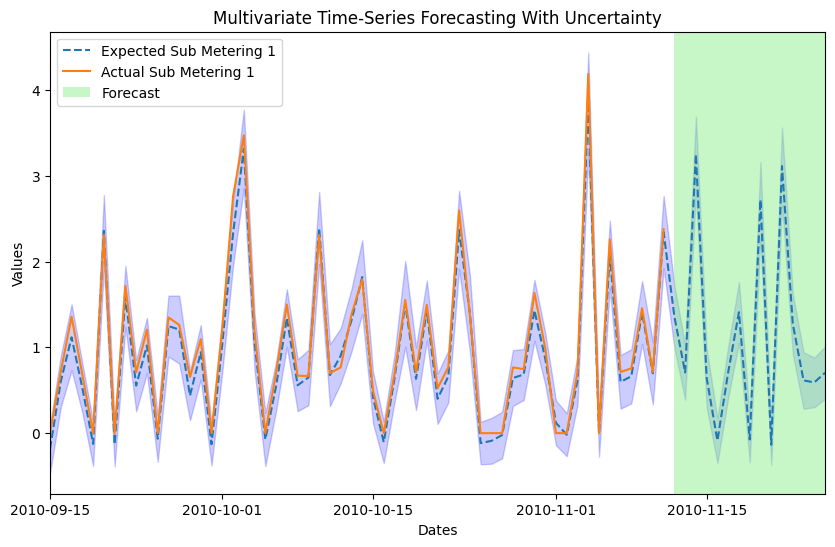

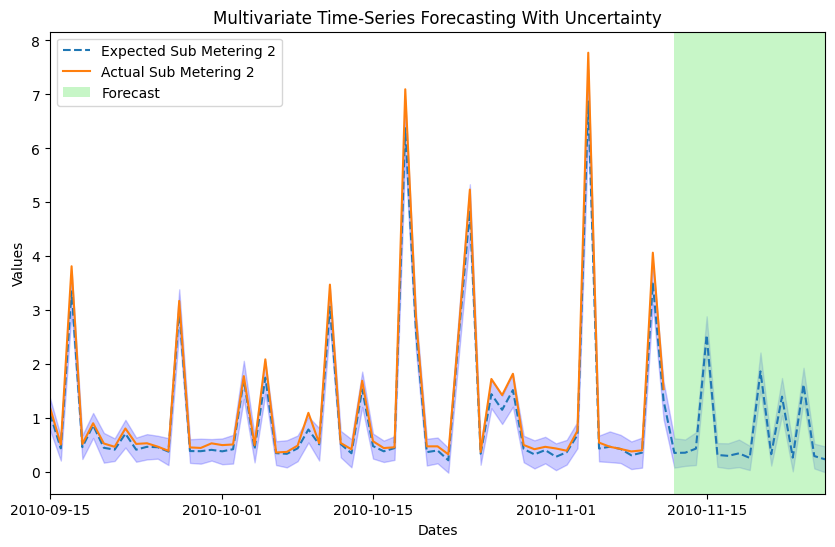

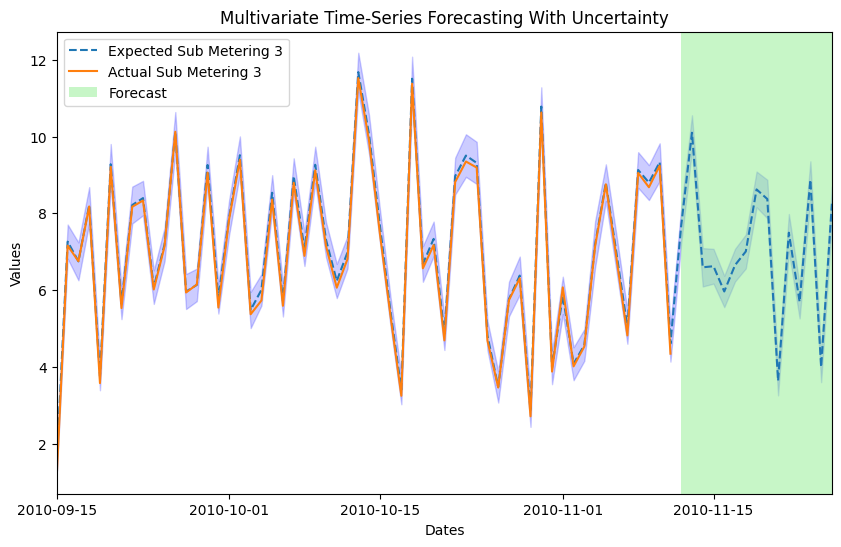

In [59]:
forecast_power_with_uncertainty(df_expected_mean_daily_transformer, df_expected_std_daily_transformer, df_actual_daily_transformer)

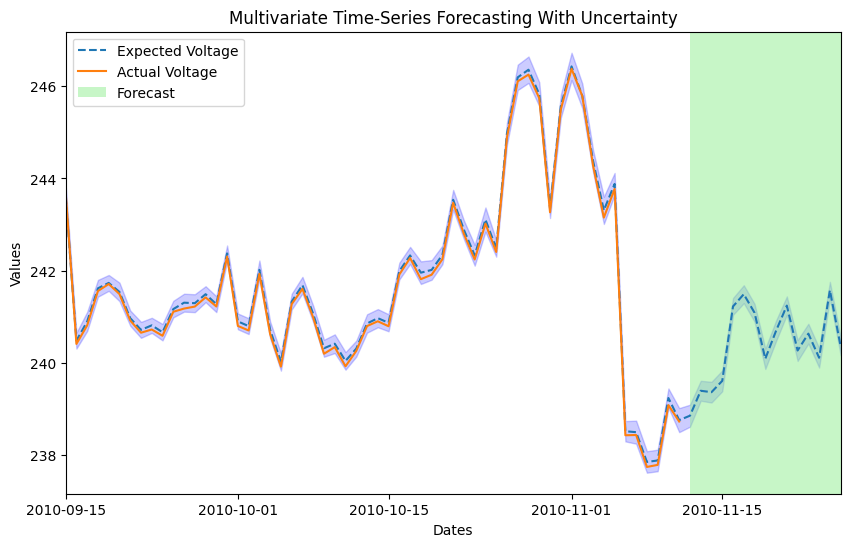

In [60]:
forecast_voltage_with_uncertainty(df_expected_mean_daily_transformer, df_expected_std_daily_transformer, df_actual_daily_transformer)